In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:
files = ['experiments_hgx.csv', 'experiments_gtx1650.csv']

In [109]:
serial = pd.read_csv('experiments/serial.csv')

In [110]:
serial = serial[(serial["threads"] == 0) | (serial["threads"] == 10)]

In [111]:
serial

,threads,iterations,time
0,0,10,9.132269
1,0,100,42.168751
2,0,1000,349.120333
3,0,10000,3398.296698
4,0,100000,33871.424540
14,10,10,1.793992
24,10,100,8.430603
34,10,1000,82.135613
44,10,10000,891.072009
54,10,100000,9454.067758


Text(0.5, 1.0, 'OpenMP - Serial vs 10 threads - Execution time')

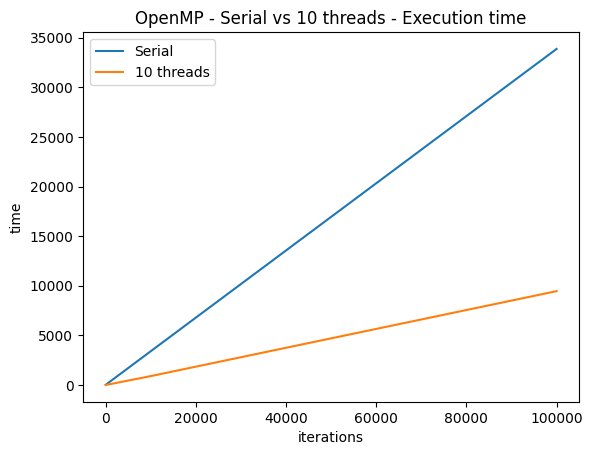

In [112]:
sns.lineplot(serial[serial["threads"] == 0], x="iterations", y="time", label="Serial")
sns.lineplot(
    serial[serial["threads"] == 10], x="iterations", y="time", label="10 threads"
)
plt.title("OpenMP - Serial vs 10 threads - Execution time")

In [113]:
def calculate_speedup(row):
    first_execution_time = row.loc[row["threads"] == 0, ["time"]].time.item()
    row["speed_up"] = first_execution_time / row["time"]
    cp = row.copy()
    cp[cp["threads"] == 0] = 1
    row["efficiency"] = row["speed_up"] / cp["threads"]
    return row

In [114]:
grouped_by_iterations = (
    serial.groupby("iterations")
    .apply(calculate_speedup, include_groups=False)
    .reset_index()
)
grouped_by_iterations.drop(columns=["level_1"], inplace=True)

In [115]:
grouped_by_iterations

,iterations,threads,time,speed_up,efficiency
0,10,0,9.132269,1.000000,1.000000
1,10,10,1.793992,5.090474,0.509047
2,100,0,42.168751,1.000000,1.000000
3,100,10,8.430603,5.001867,0.500187
4,1000,0,349.120333,1.000000,1.000000
5,1000,10,82.135613,4.250535,0.425054
6,10000,0,3398.296698,1.000000,1.000000
7,10000,10,891.072009,3.813717,0.381372
8,100000,0,33871.424540,1.000000,1.000000
9,100000,10,9454.067758,3.582736,0.358274


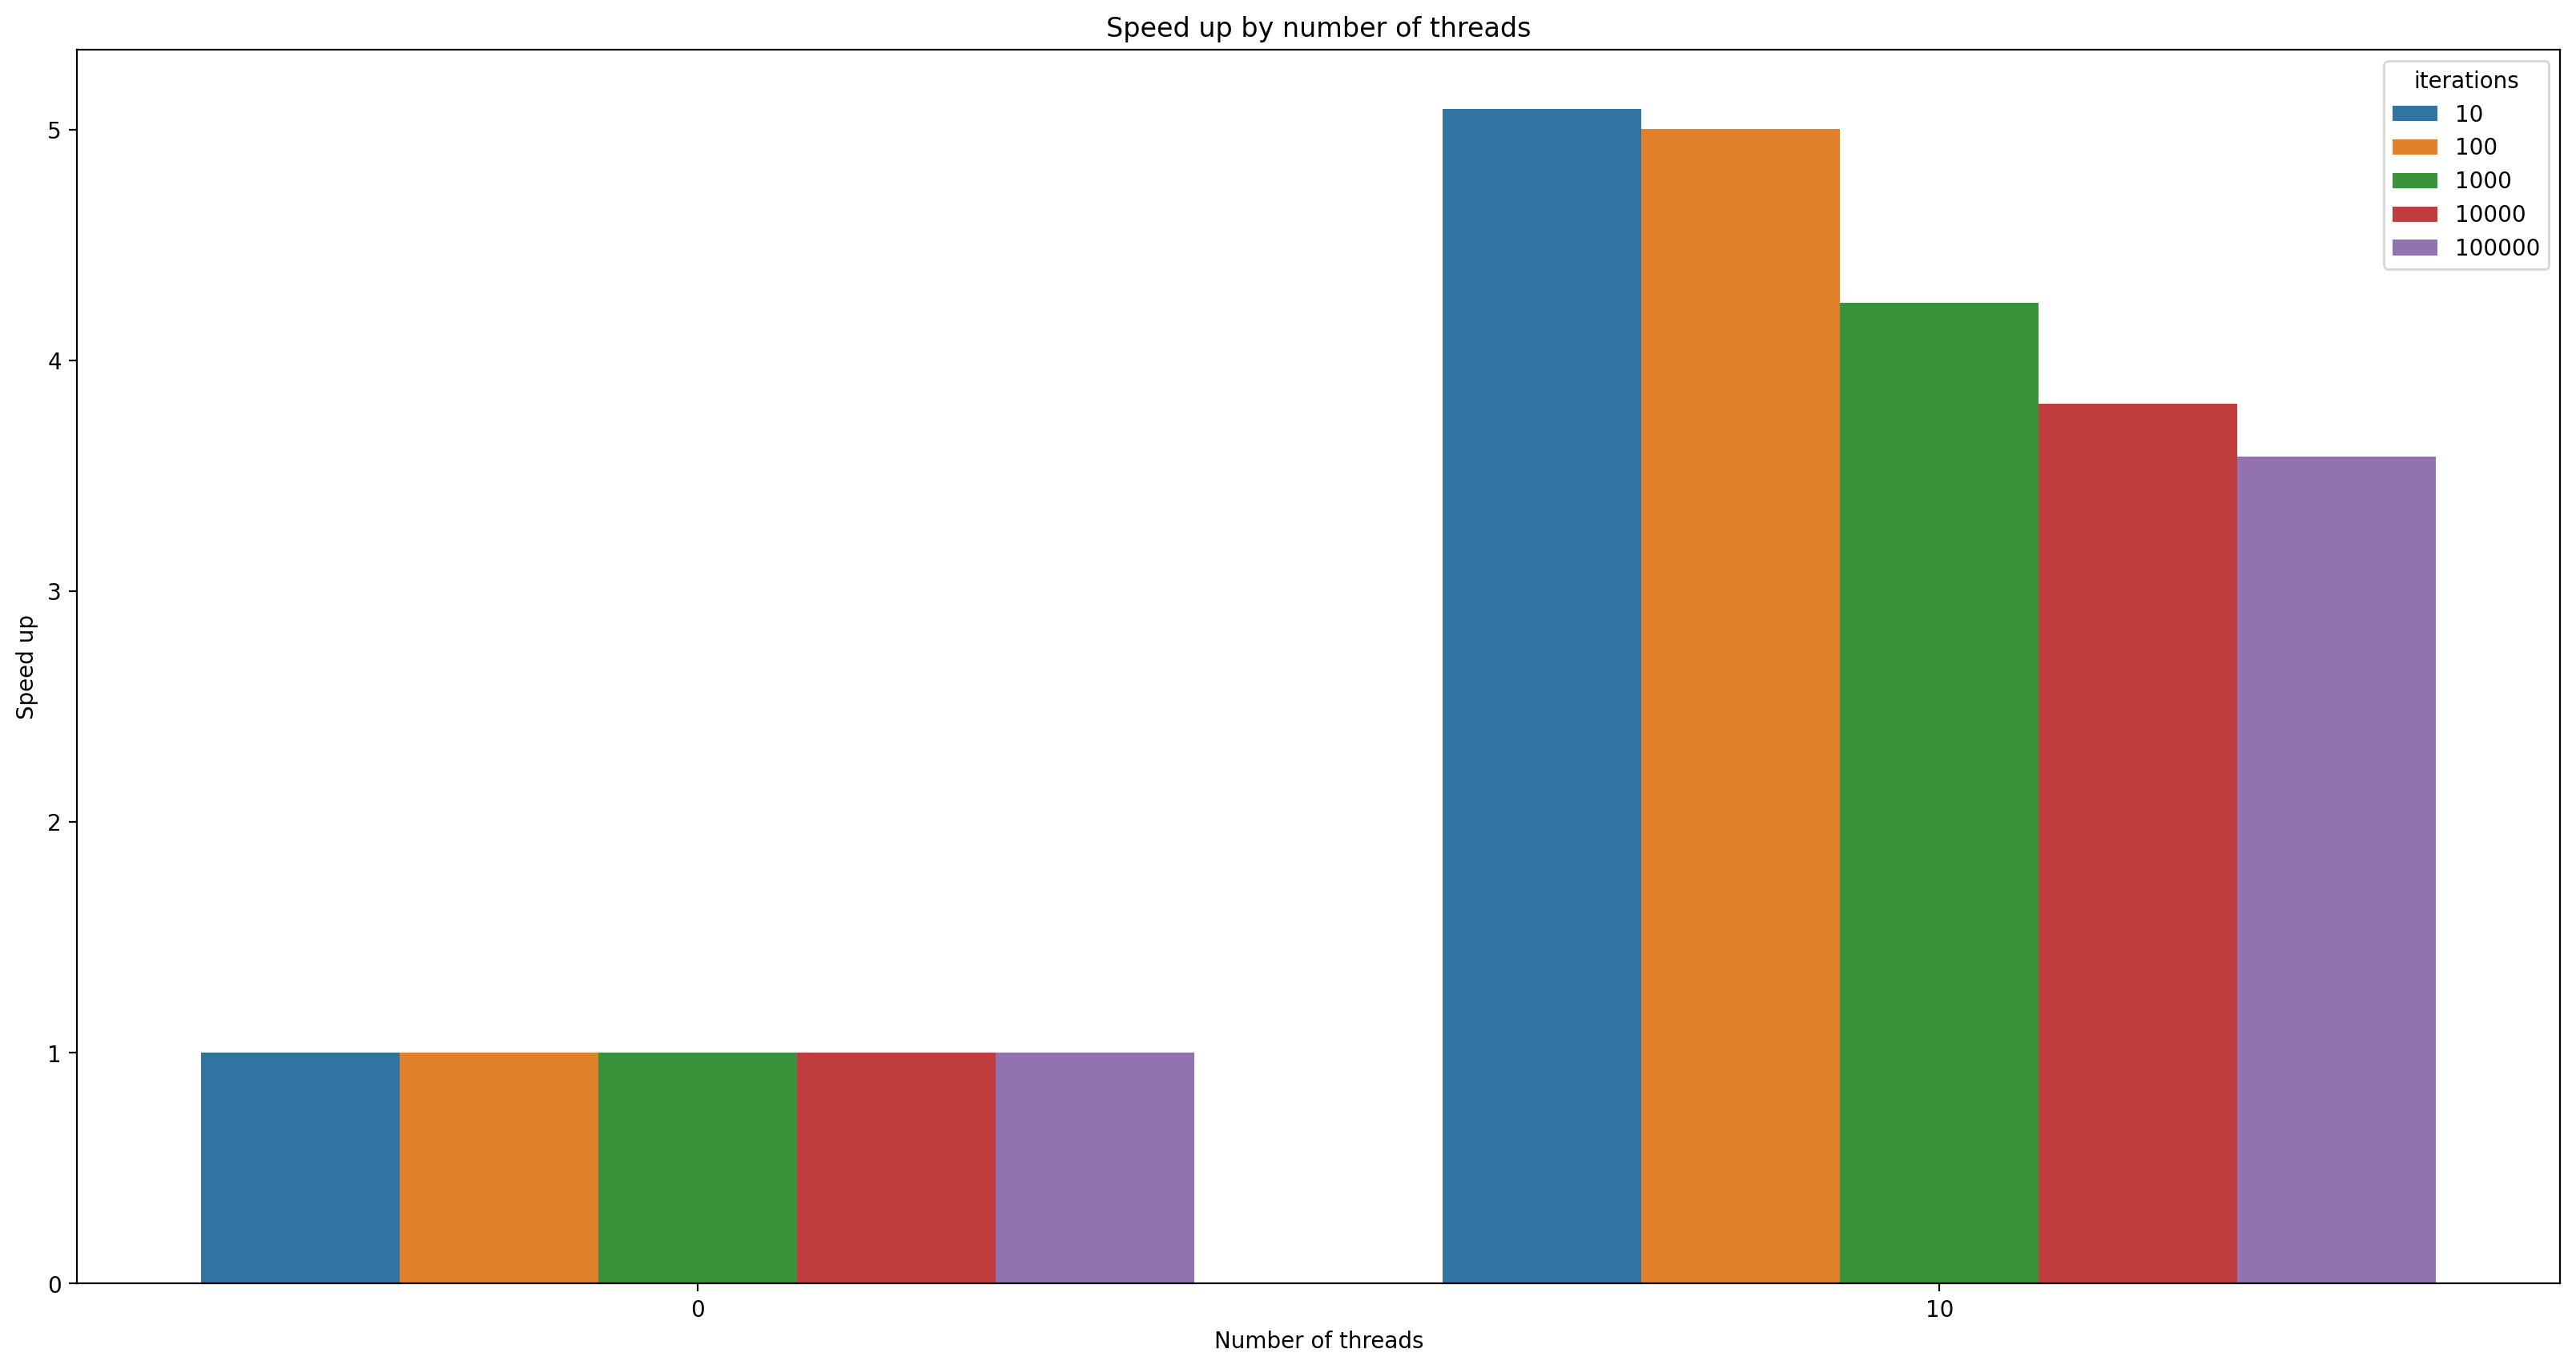

In [116]:
plt.figure(figsize=(20, 10), dpi=200)
chart = sns.barplot(
    grouped_by_iterations,
    x="threads",
    y="speed_up",
    hue="iterations",
    palette="tab10",
)
chart.set_ylabel("Speed up")
chart.set_xlabel("Number of threads")
chart.set_title("Speed up by number of threads")
plt.savefig("charts/serial_mp_speed_up.png", bbox_inches="tight")

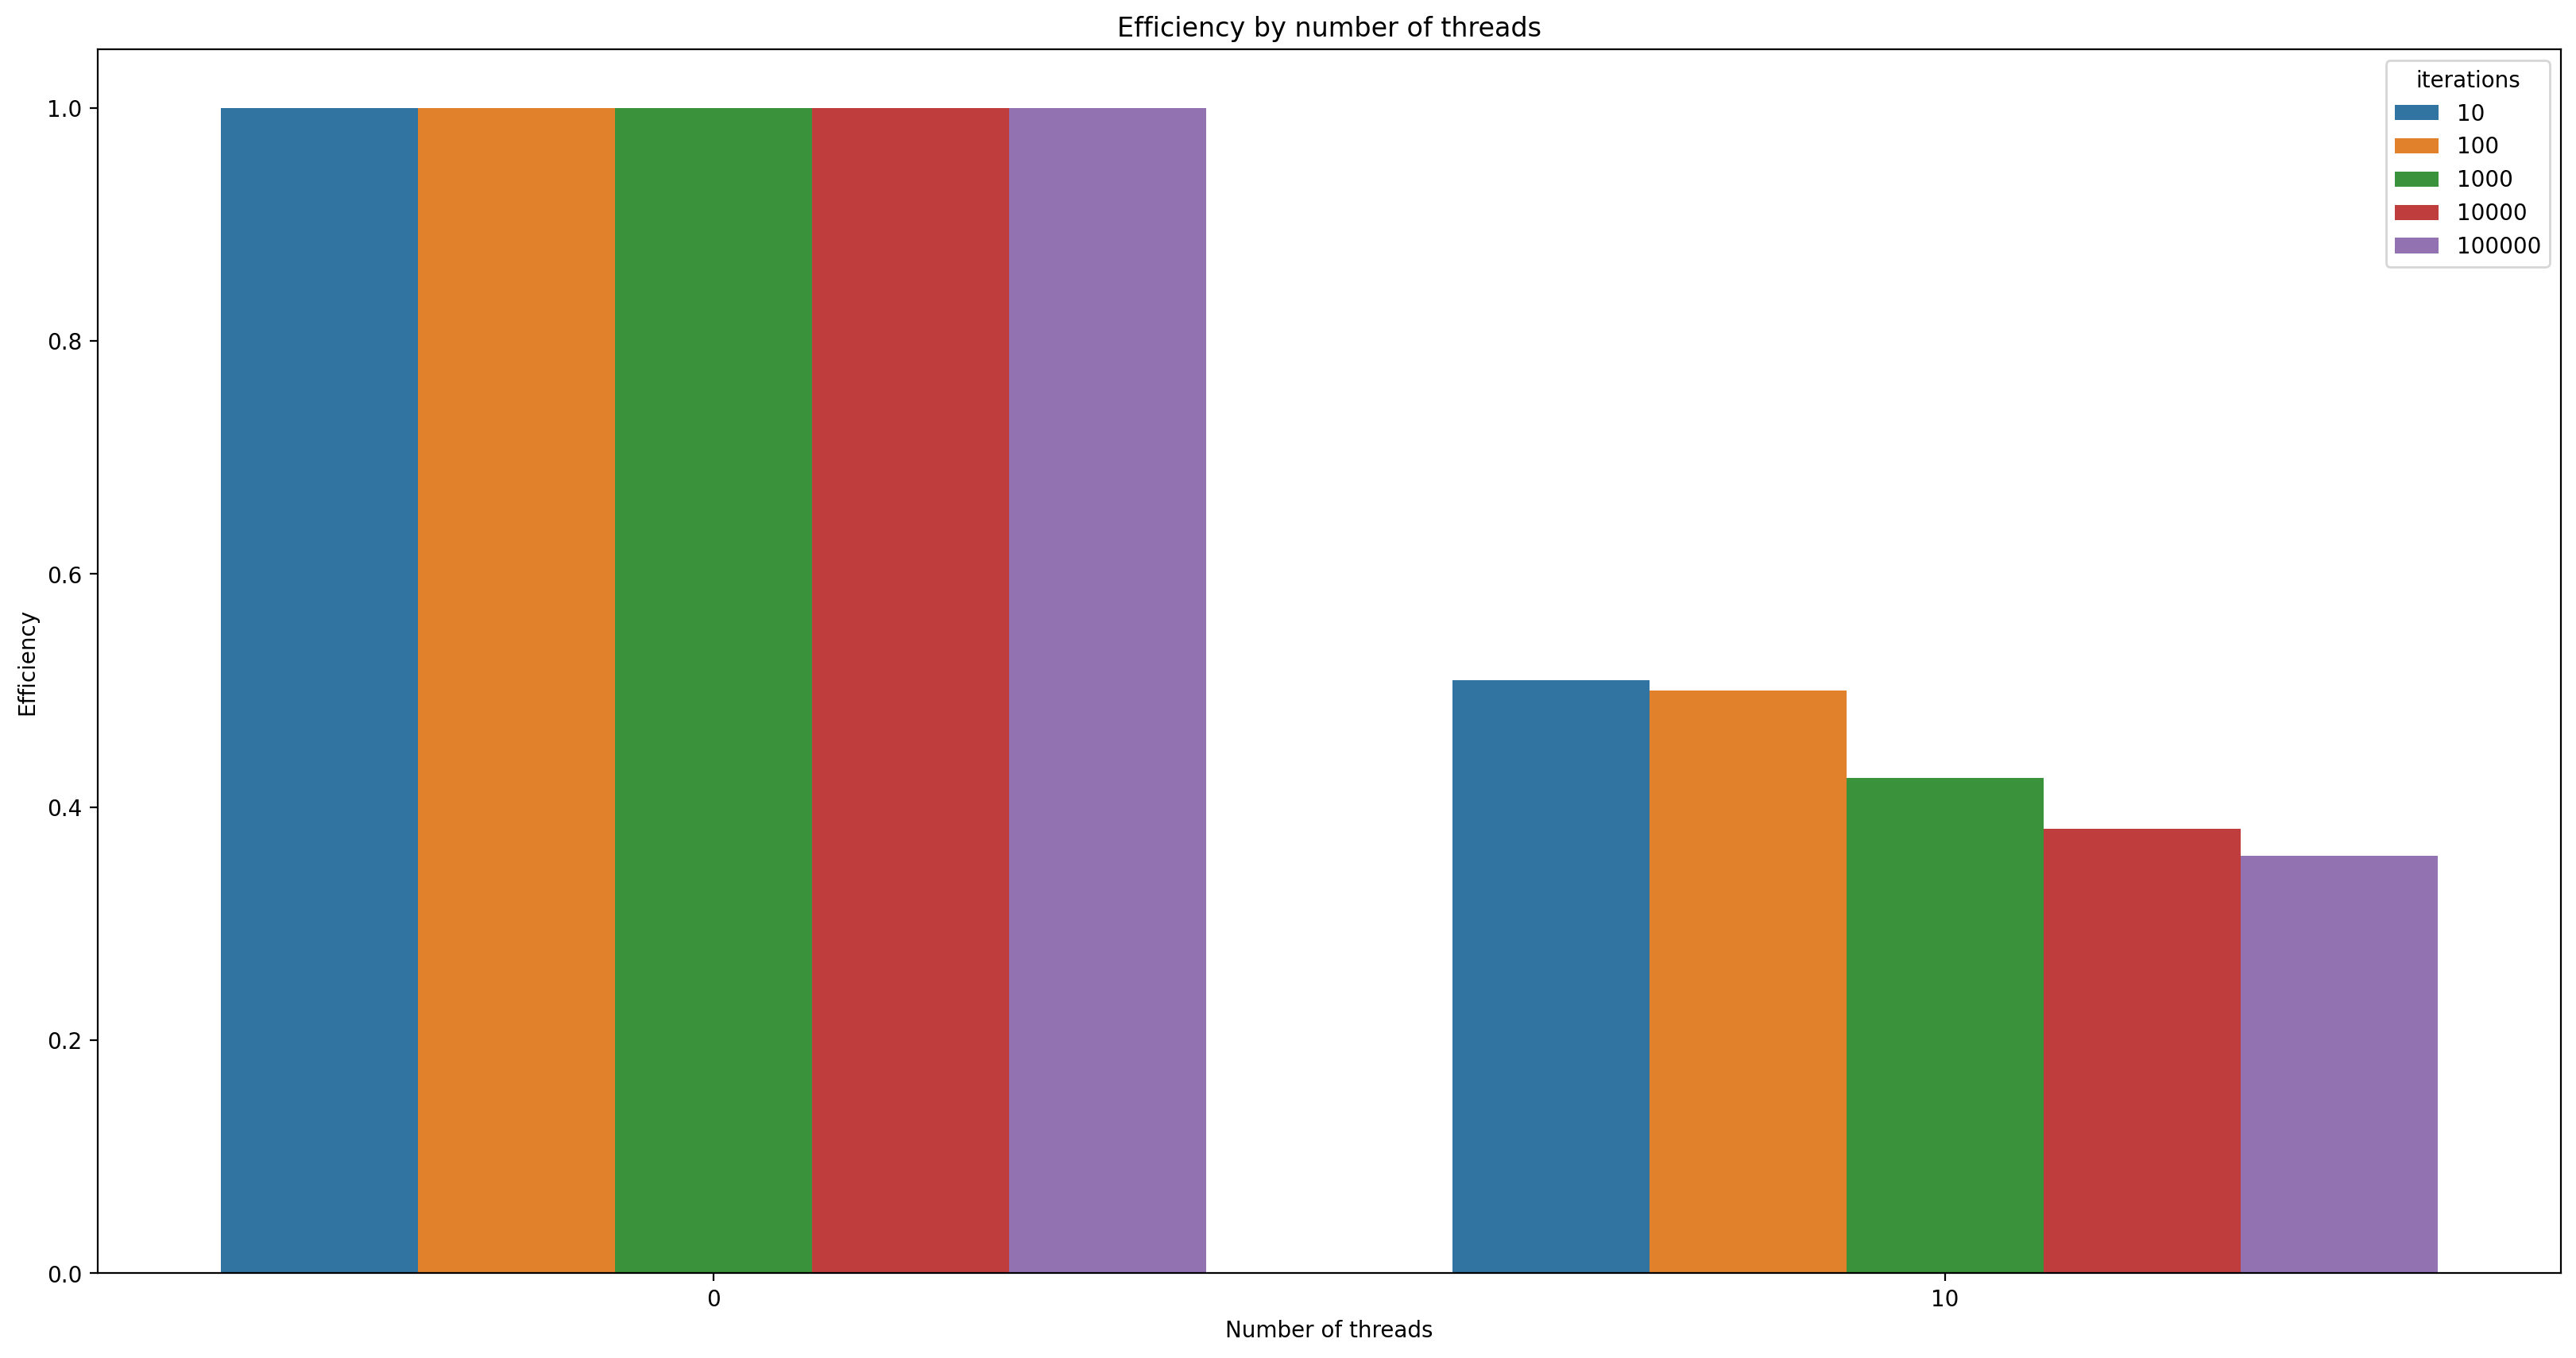

In [117]:
plt.figure(figsize=(20, 10), dpi=200)
chart = sns.barplot(
    grouped_by_iterations,
    x="threads",
    y="efficiency",
    hue="iterations",
    palette="tab10",
)
chart.set_ylabel("Efficiency")
chart.set_xlabel("Number of threads")
chart.set_title("Efficiency by number of threads")
plt.savefig("charts/serial_mp_efficiency.png", bbox_inches="tight")

In [118]:
base = serial[(serial["iterations"] == 100000) | (serial["iterations"] == 10000)].copy()

In [119]:
base

,threads,iterations,time
3,0,10000,3398.296698
4,0,100000,33871.424540
44,10,10000,891.072009
54,10,100000,9454.067758


In [120]:
data_gtx = pd.read_csv('experiments/experiments_gtx1650.csv')
data_hgx = pd.read_csv('experiments/experiments_hgx.csv')

In [121]:
data_gtx["iterations"] = data_gtx["maxIterations"]
data_hgx["iterations"] = data_hgx["maxIterations"]

data_gtx["time"] = data_gtx["time"] / 1000
data_hgx["time"] = data_hgx["time"] / 1000

data_hgx.drop(columns=["maxIterations"], inplace=True)
data_gtx.drop(columns=["maxIterations"], inplace=True)

data_gtx = data_gtx[
    (data_gtx["iterations"] == 100000) | (data_gtx["iterations"] == 10000)
].copy()

data_hgx = data_hgx[
    (data_hgx["iterations"] == 100000) | (data_hgx["iterations"] == 10000)
].copy()
data_gtx.reset_index(inplace=True, drop=True)
data_hgx.reset_index(inplace=True, drop=True)

In [122]:
data_gtx

,computeUnits,globalSize,localSize,time,iterations
0,14,"[7680,4320]","[32,32]",0.277460,10000
1,14,"[7680,4320]","[32,32]",2.566046,100000


In [123]:
data_hgx

,computeUnits,globalSize,localSize,time,iterations
0,108,"[7680,4320]","[32,32]",0.050333,10000
1,108,"[7680,4320]","[32,32]",0.387145,100000


In [124]:
data_gpu = pd.concat([data_gtx, data_hgx], axis=0)

In [125]:
data_gpu["gpu"] = True
data_gpu["threads"] = data_gpu["computeUnits"]
data_gpu.drop(columns=["computeUnits", "localSize", "globalSize"], inplace=True)
data_gpu

,time,iterations,gpu,threads
0,0.277460,10000,True,14
1,2.566046,100000,True,14
0,0.050333,10000,True,108
1,0.387145,100000,True,108


In [126]:
data = pd.concat([base, data_gpu], axis=0)
data.reset_index(inplace=True, drop=True)
data

,threads,iterations,time,gpu
0,0,10000,3398.296698,NaN
1,0,100000,33871.424540,NaN
2,10,10000,891.072009,NaN
3,10,100000,9454.067758,NaN
4,14,10000,0.277460,True
5,14,100000,2.566046,True
6,108,10000,0.050333,True
7,108,100000,0.387145,True


In [127]:
def calculate_speedup_gpu(row):
    first_execution_time = row.loc[row["threads"] == 0, ["time"]].time.item()
    row["speed_up_serial"] = first_execution_time / row["time"]
    cp = row.copy()
    cp[cp["threads"] == 0] = 1
    row["efficiency_serial"] = row["speed_up_serial"] / cp["threads"]

    first_execution_time = row.loc[row["threads"] == 10, ["time"]].time.item()
    row["speed_up_parallel"] = first_execution_time / row["time"]
    cp = row.copy()
    cp[cp["threads"] == 0] = 1
    row["efficiency_parallel"] = row["speed_up_parallel"] / cp["threads"]

    return row

In [128]:
grouped_by_iterations = data.groupby("iterations").apply(
    calculate_speedup_gpu, include_groups=False
).reset_index()
grouped_by_iterations.drop(columns=["level_1"], inplace=True)
grouped_by_iterations

,iterations,threads,time,gpu,speed_up_serial,efficiency_serial,speed_up_parallel,efficiency_parallel
0,10000,0,3398.296698,NaN,1.000000,1.000000,0.262211,0.262211
1,10000,10,891.072009,NaN,3.813717,0.381372,1.000000,0.100000
2,10000,14,0.277460,True,12247.893813,874.849558,3211.536930,229.395495
3,10000,108,0.050333,True,67516.715544,625.154774,17703.650007,163.922685
4,100000,0,33871.424540,NaN,1.000000,1.000000,0.279116,0.279116
5,100000,10,9454.067758,NaN,3.582736,0.358274,1.000000,0.100000
6,100000,14,2.566046,True,13199.852439,942.846603,3684.294388,263.163885
7,100000,108,0.387145,True,87490.347124,810.095807,24419.984725,226.110970


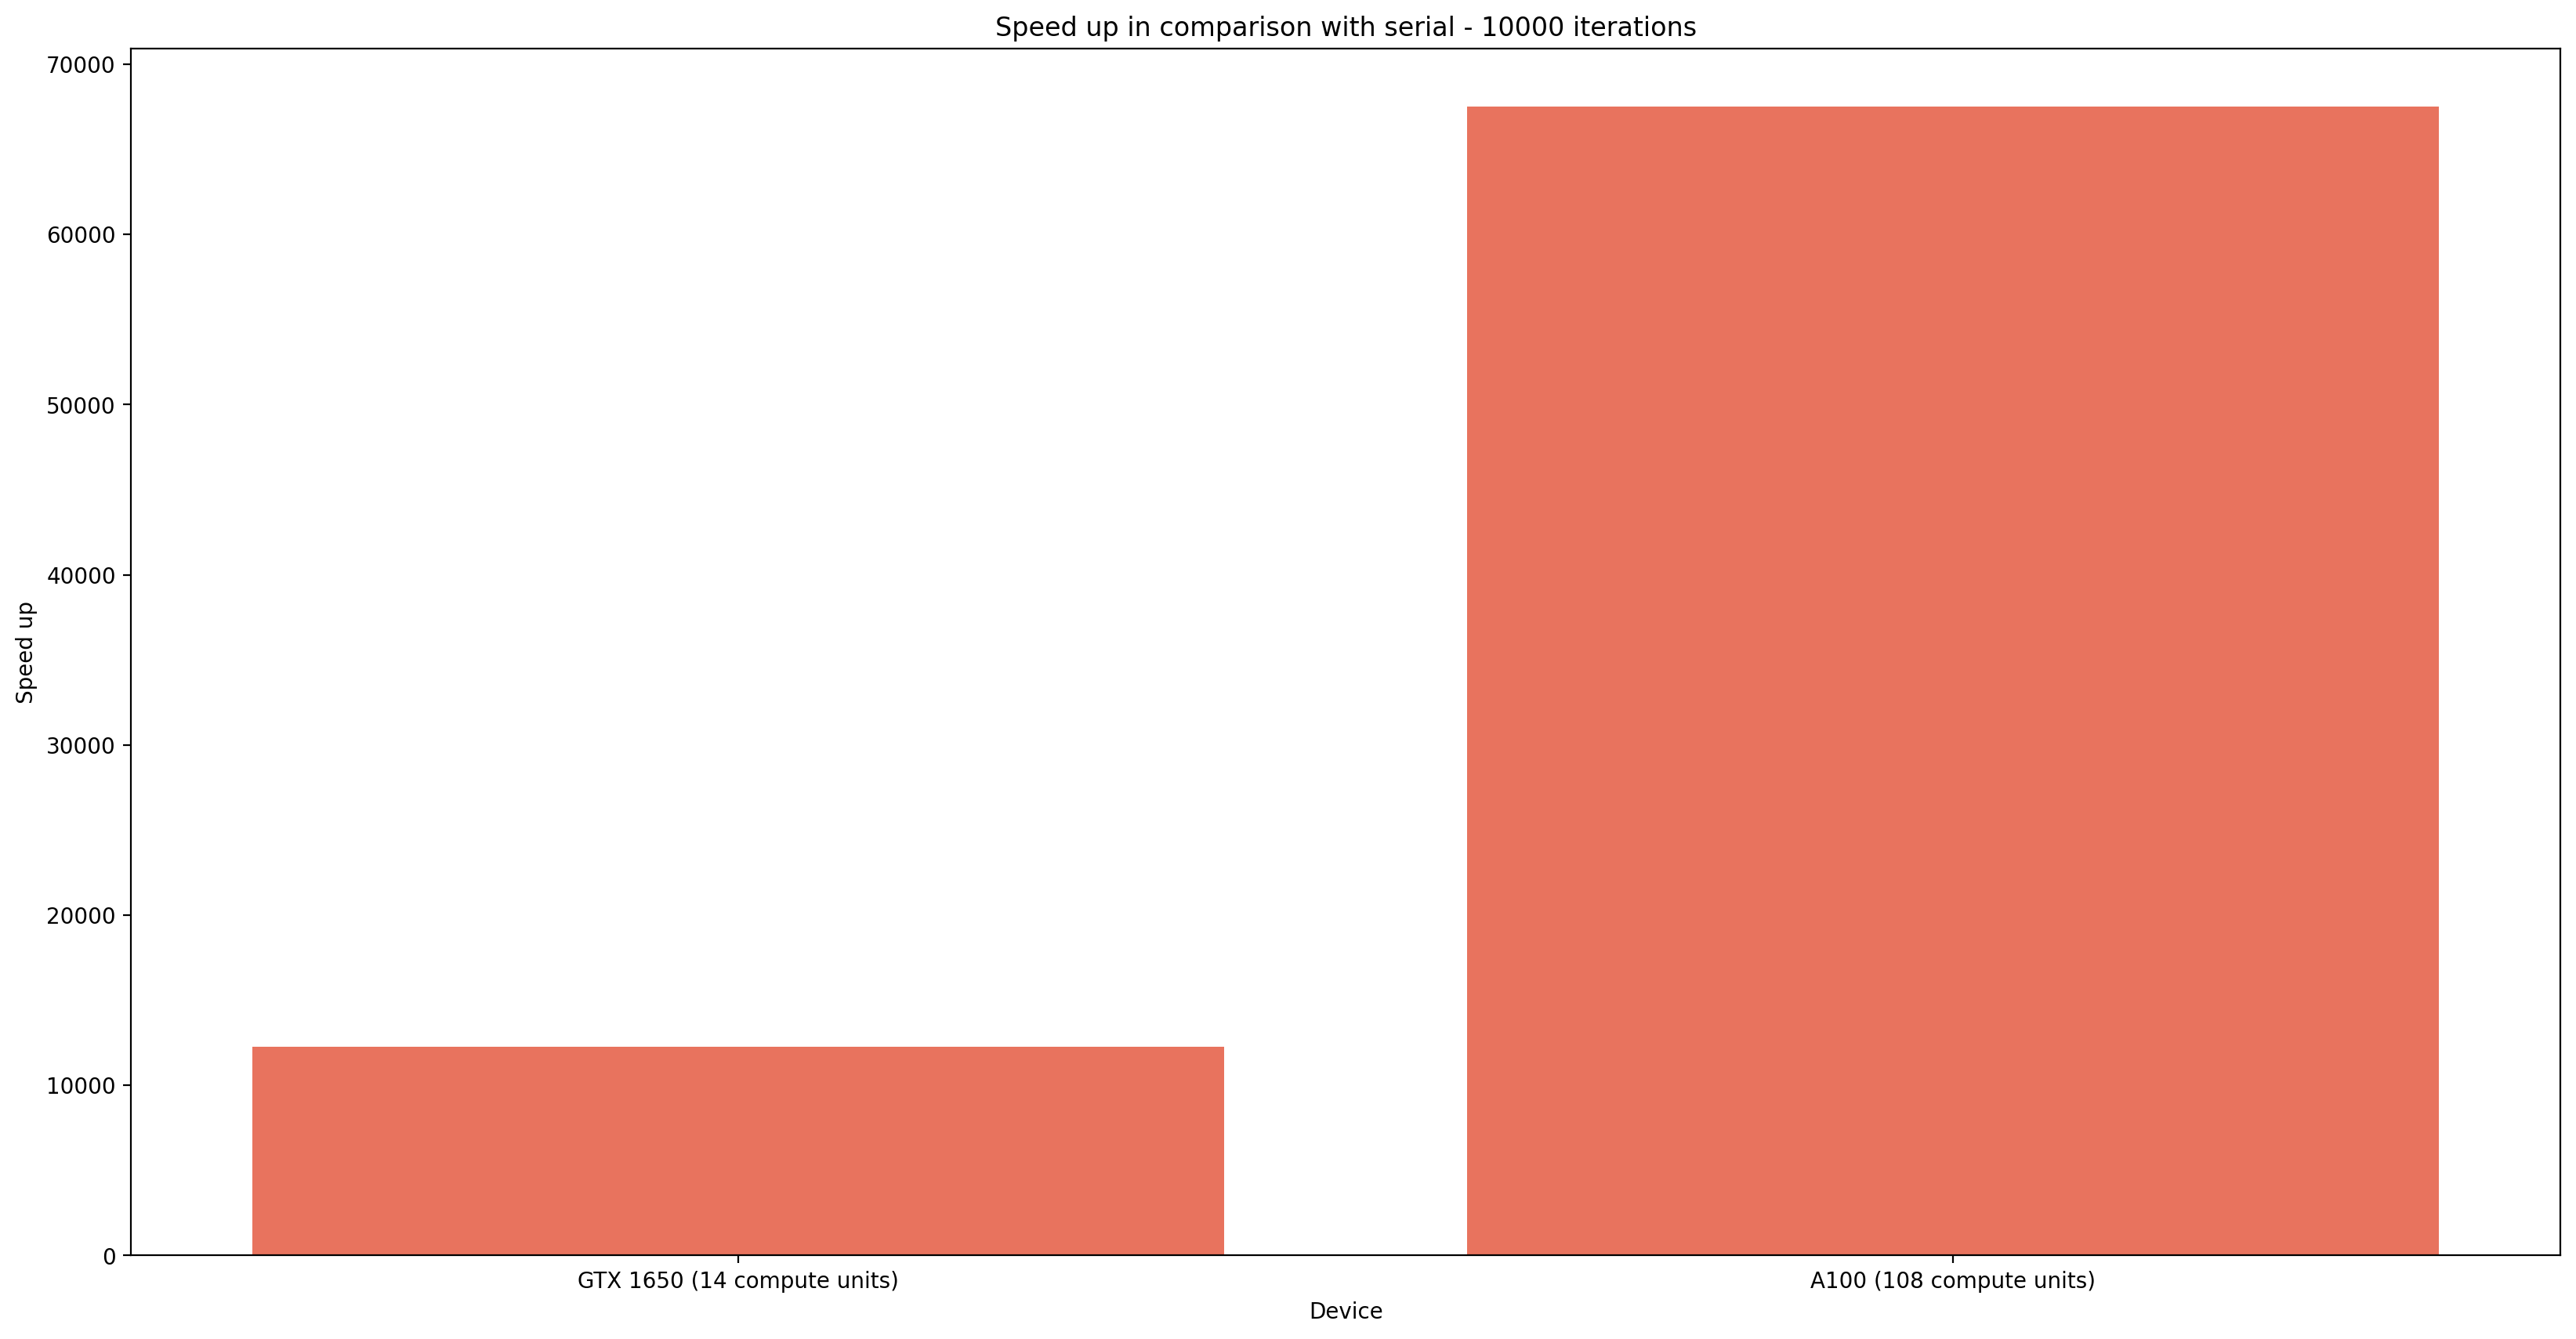

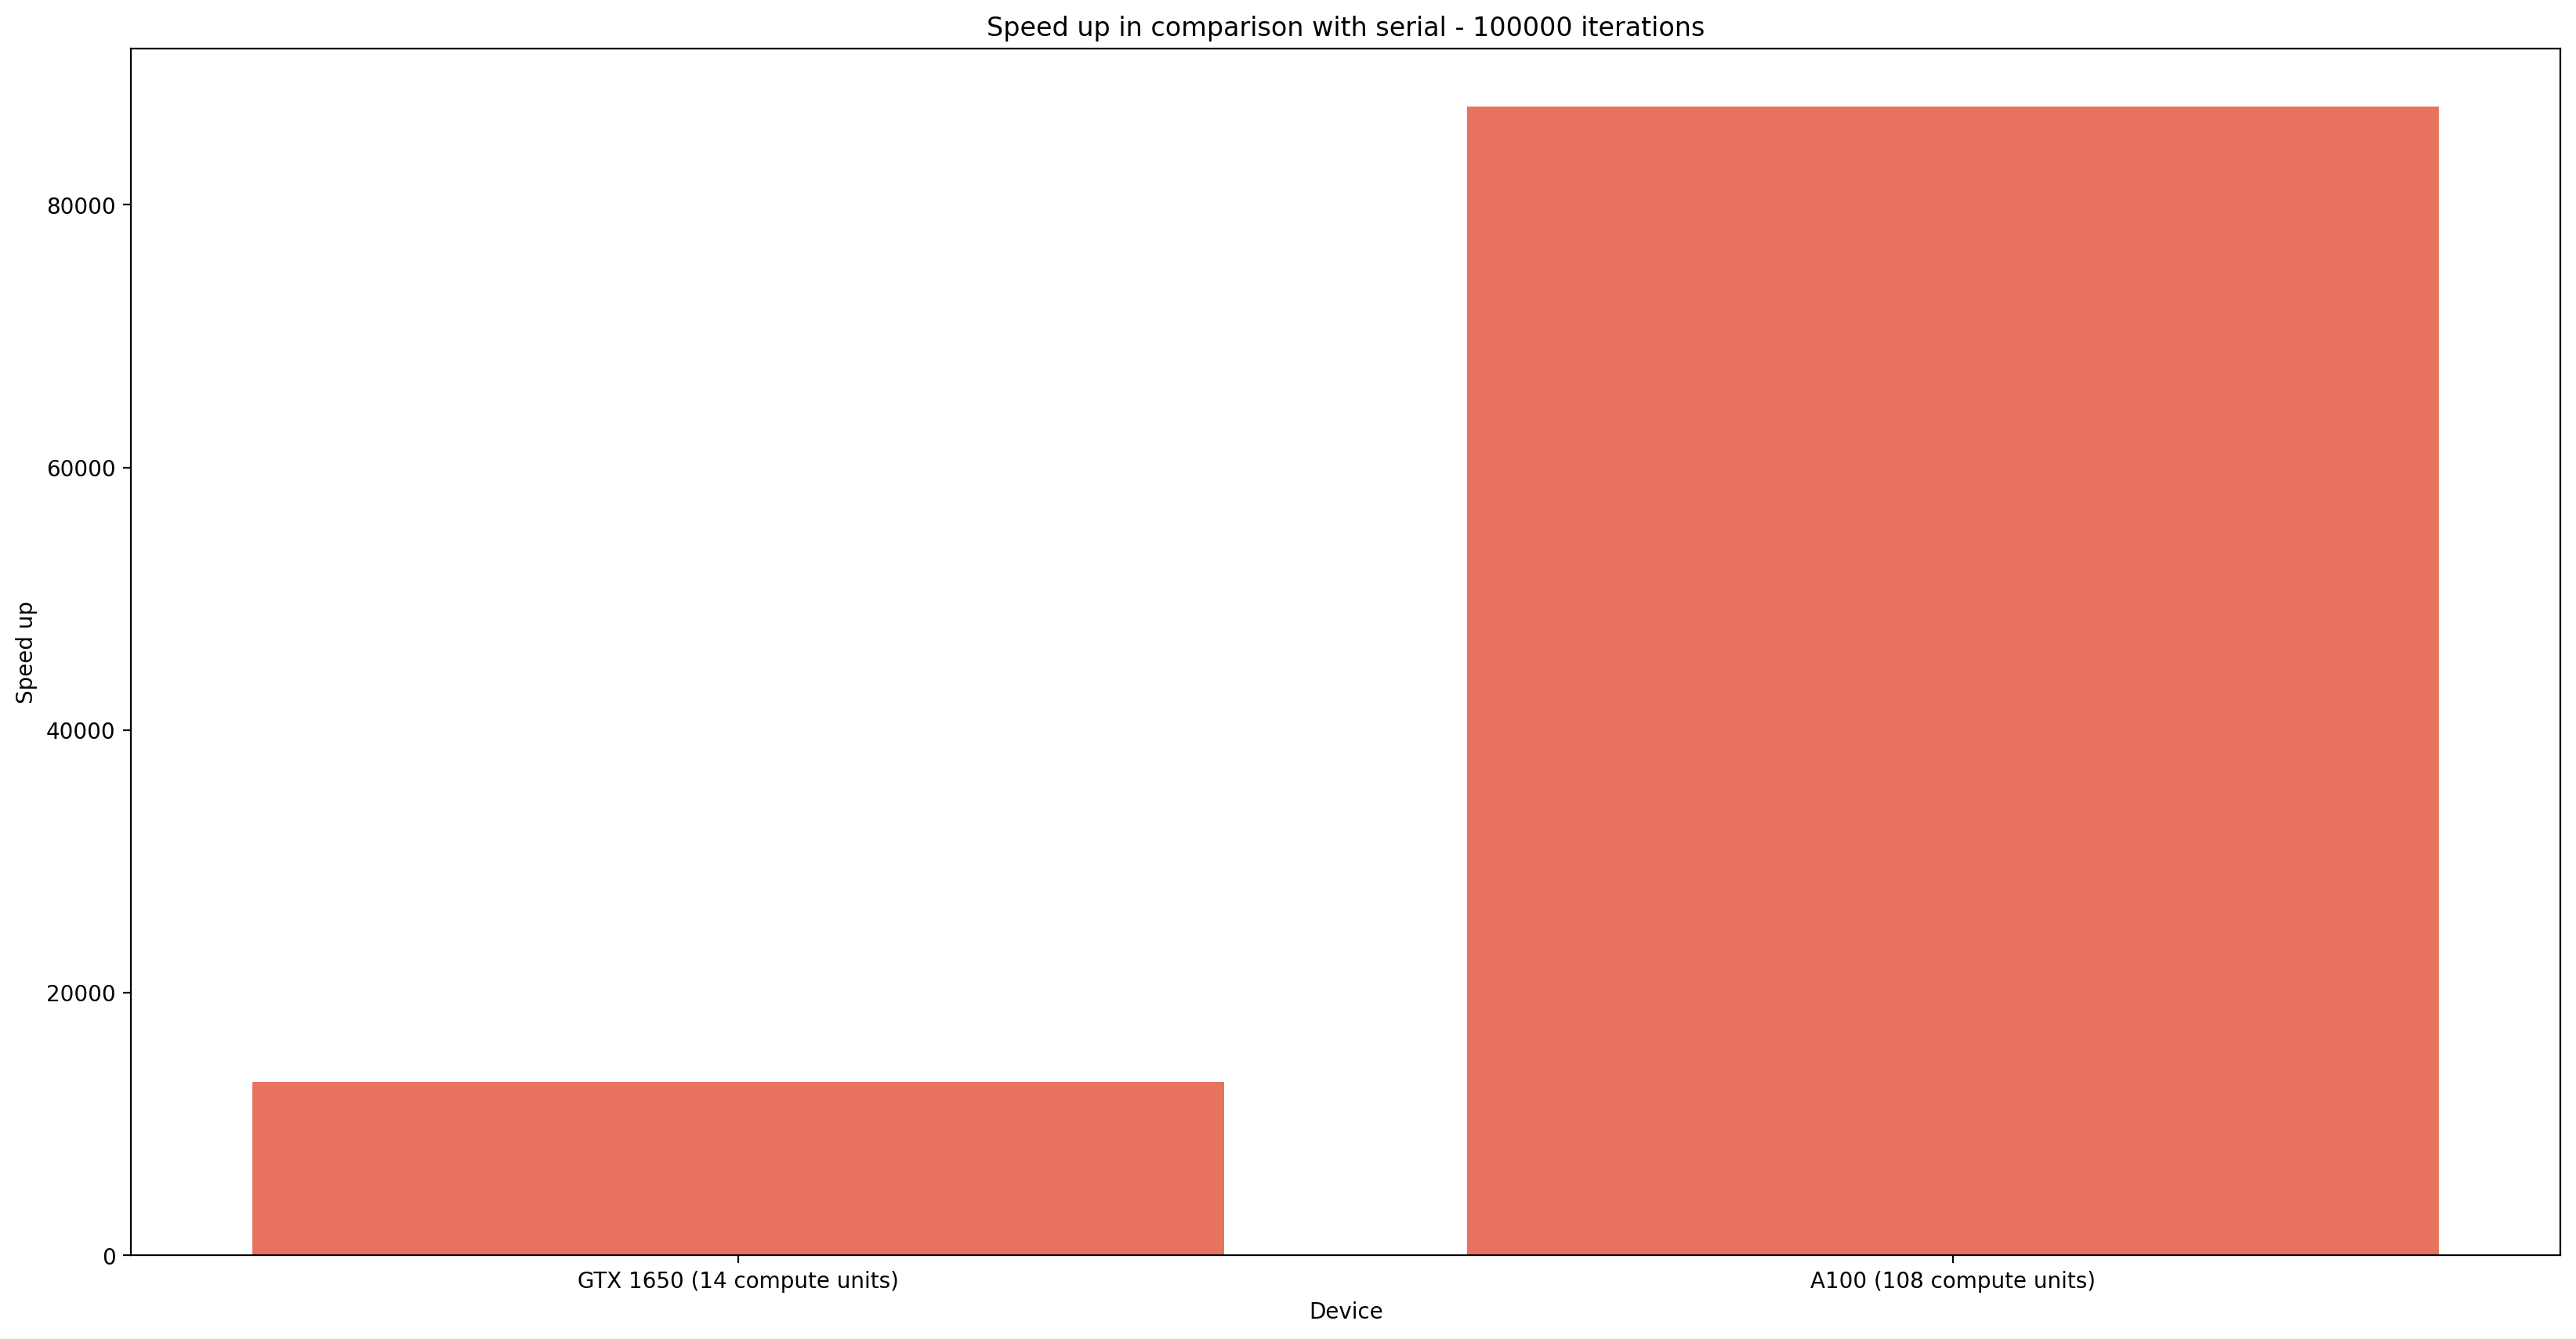

In [129]:
for it in grouped_by_iterations["iterations"].unique():
    plt.figure(figsize=(20, 10), dpi=200)
    chart = sns.barplot(
        grouped_by_iterations[
            (grouped_by_iterations["iterations"] == it)
            & (grouped_by_iterations["threads"] != 0)
            & (grouped_by_iterations["threads"] != 10)
        ],
        x=["GTX 1650 (14 compute units)", "A100 (108 compute units)"],
        y="speed_up_serial",
        color="tomato",
        legend=True,
    )
    chart.set_ylabel("Speed up")
    chart.set_xlabel("Device")
    chart.set_title(f"Speed up in comparison with serial - {it} iterations")
    plt.savefig(f"charts/speed_up_serial_{it}.png", bbox_inches="tight")

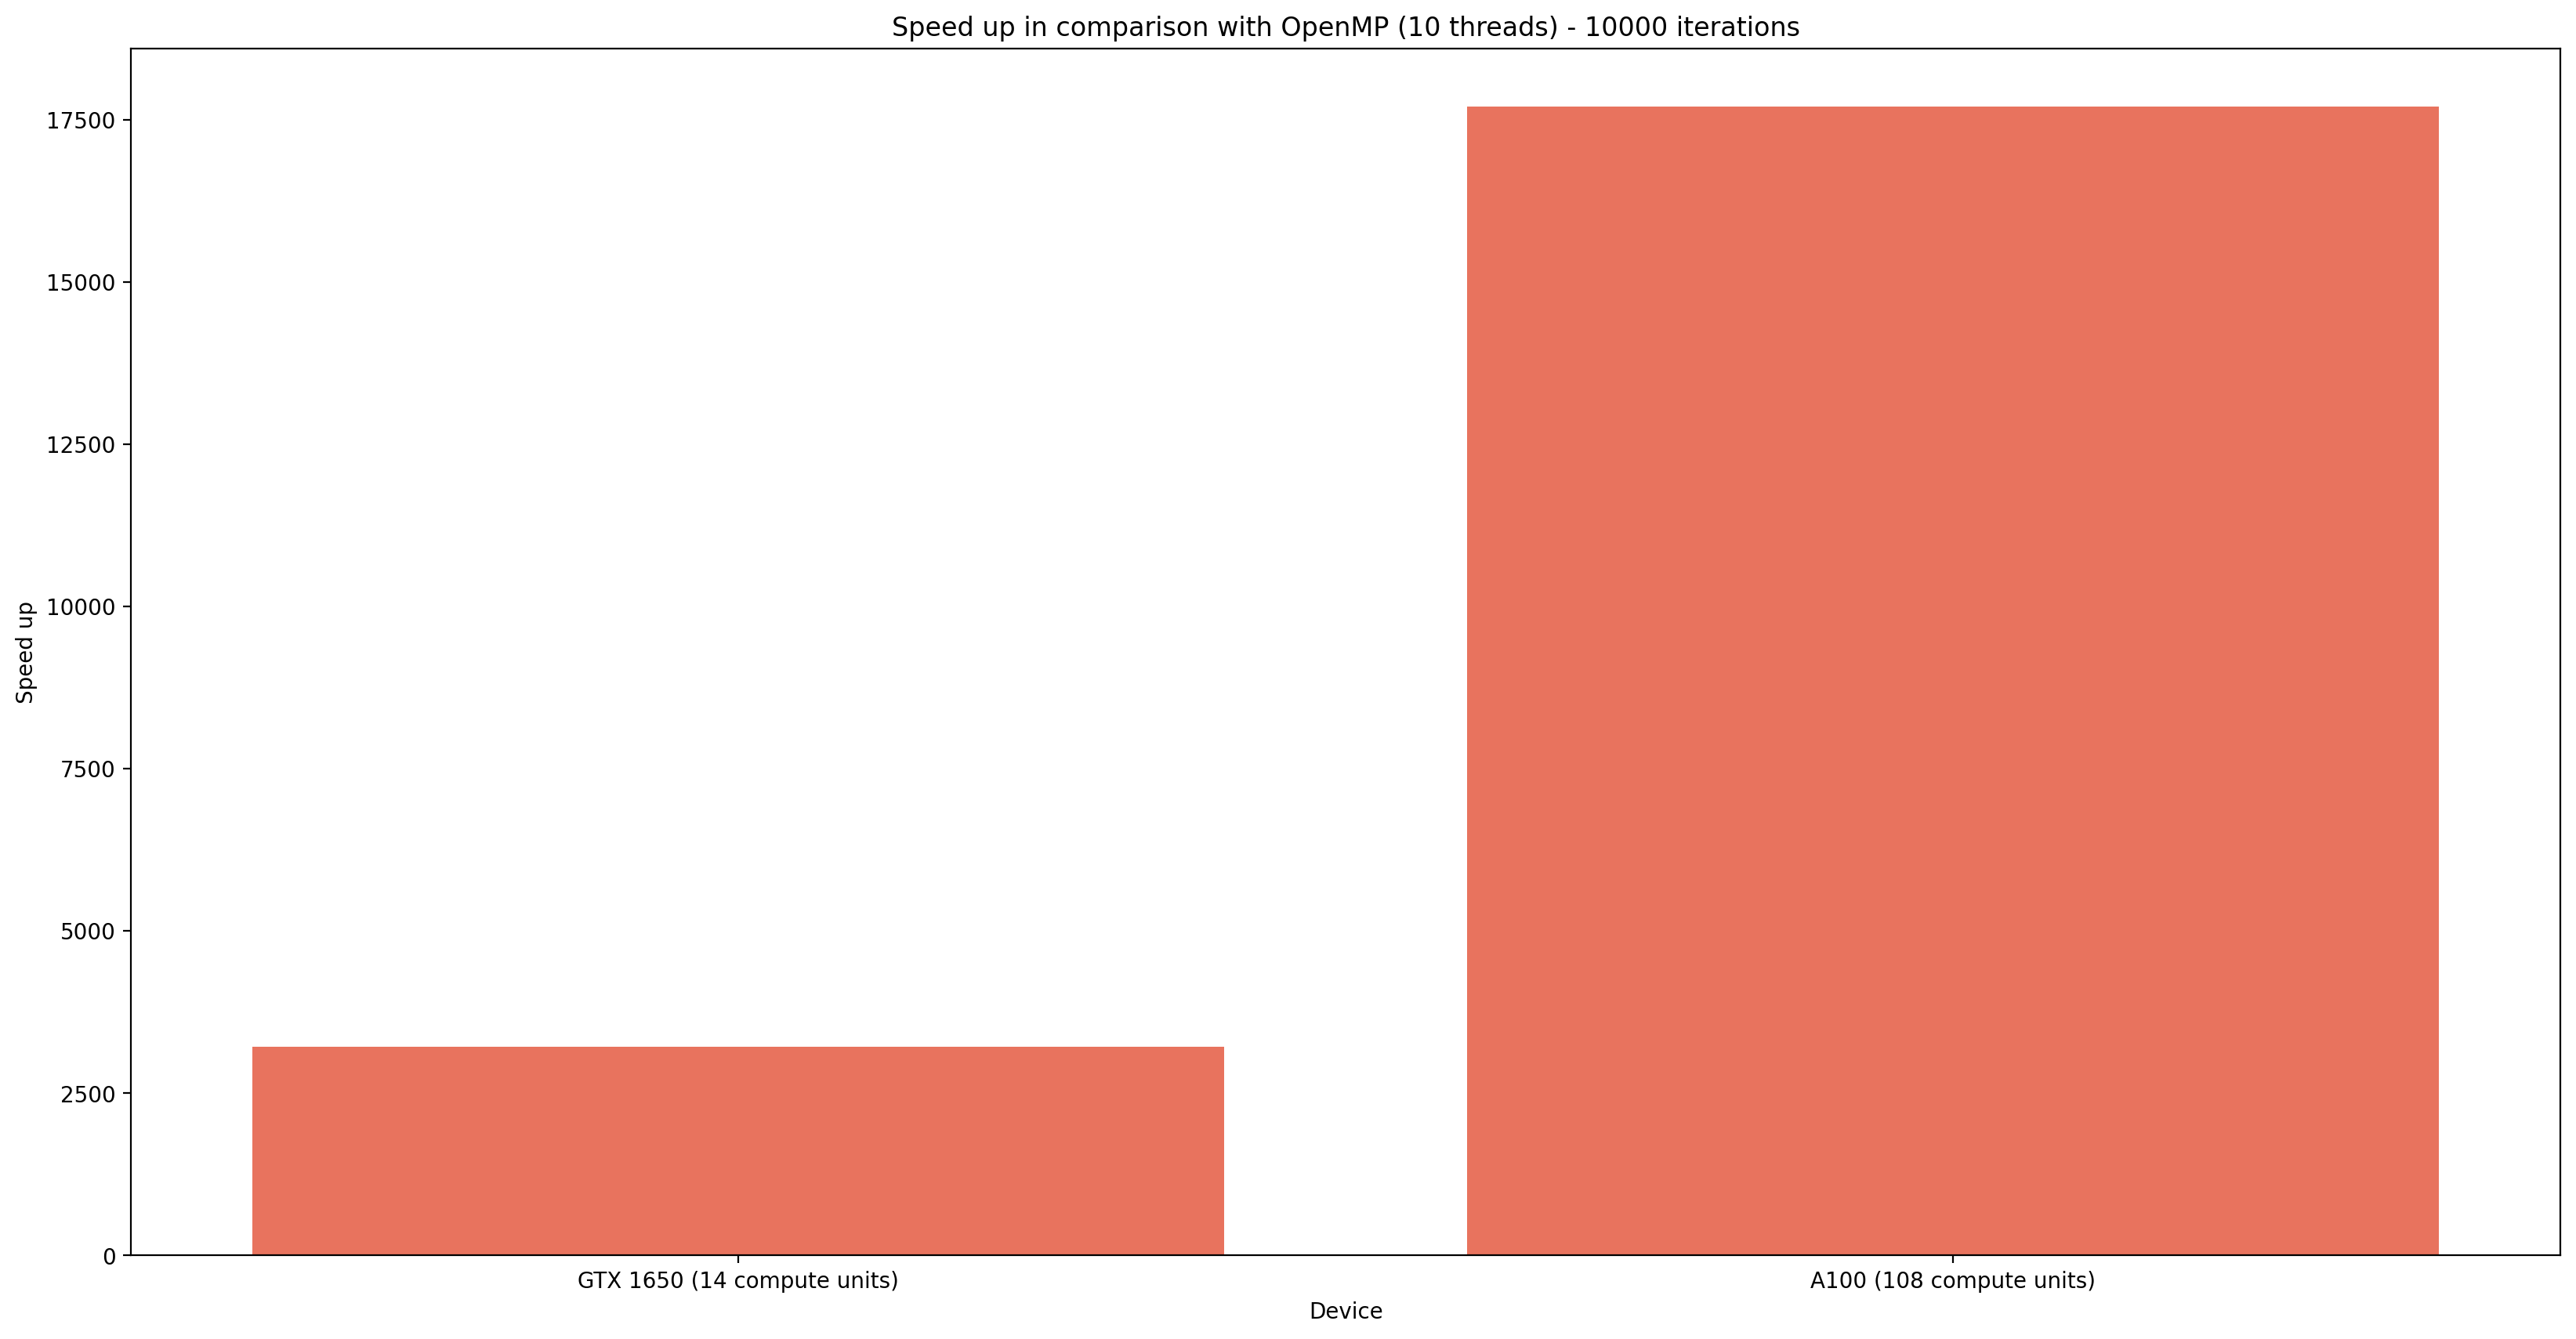

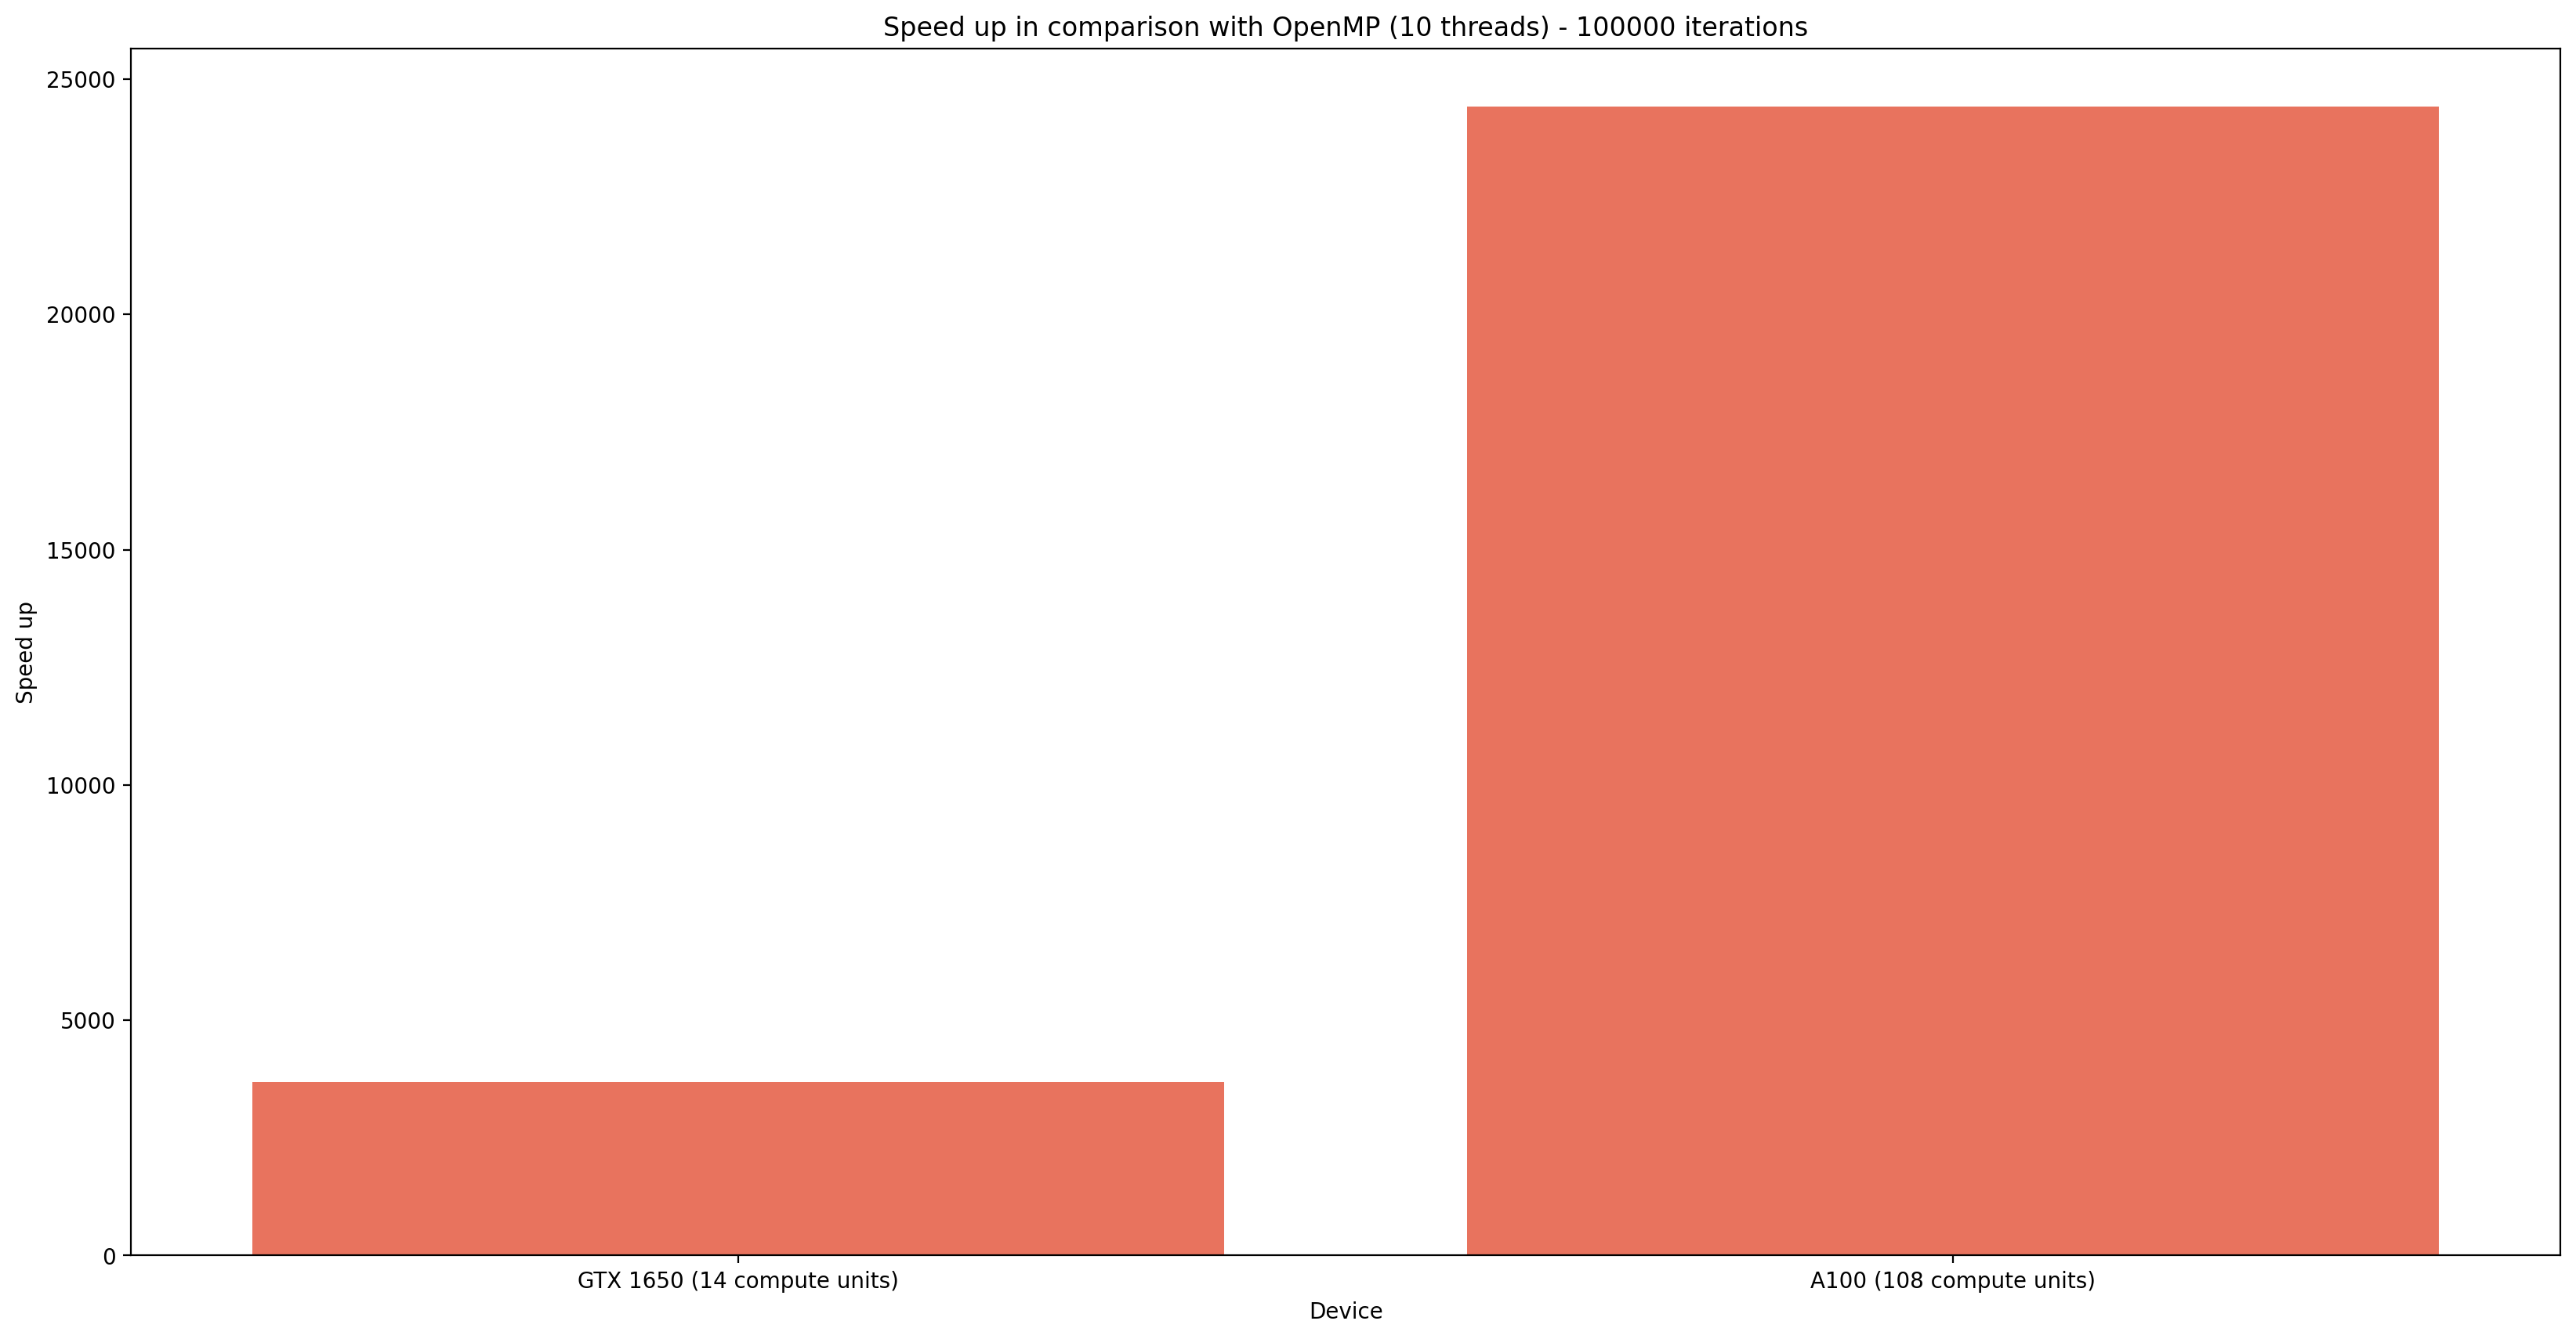

In [130]:
for it in grouped_by_iterations["iterations"].unique():
    plt.figure(figsize=(20, 10), dpi=200)
    chart = sns.barplot(
        grouped_by_iterations[
            (grouped_by_iterations["iterations"] == it)
            & (grouped_by_iterations["threads"] != 0)
            & (grouped_by_iterations["threads"] != 10)
        ],
        x=["GTX 1650 (14 compute units)", "A100 (108 compute units)"],
        y="speed_up_parallel",
        color="tomato",
        legend=True,
    )
    chart.set_ylabel("Speed up")
    chart.set_xlabel("Device")
    chart.set_title(f"Speed up in comparison with OpenMP (10 threads) - {it} iterations")
    plt.savefig(f"charts/speed_up_parallel_{it}.png", bbox_inches="tight")

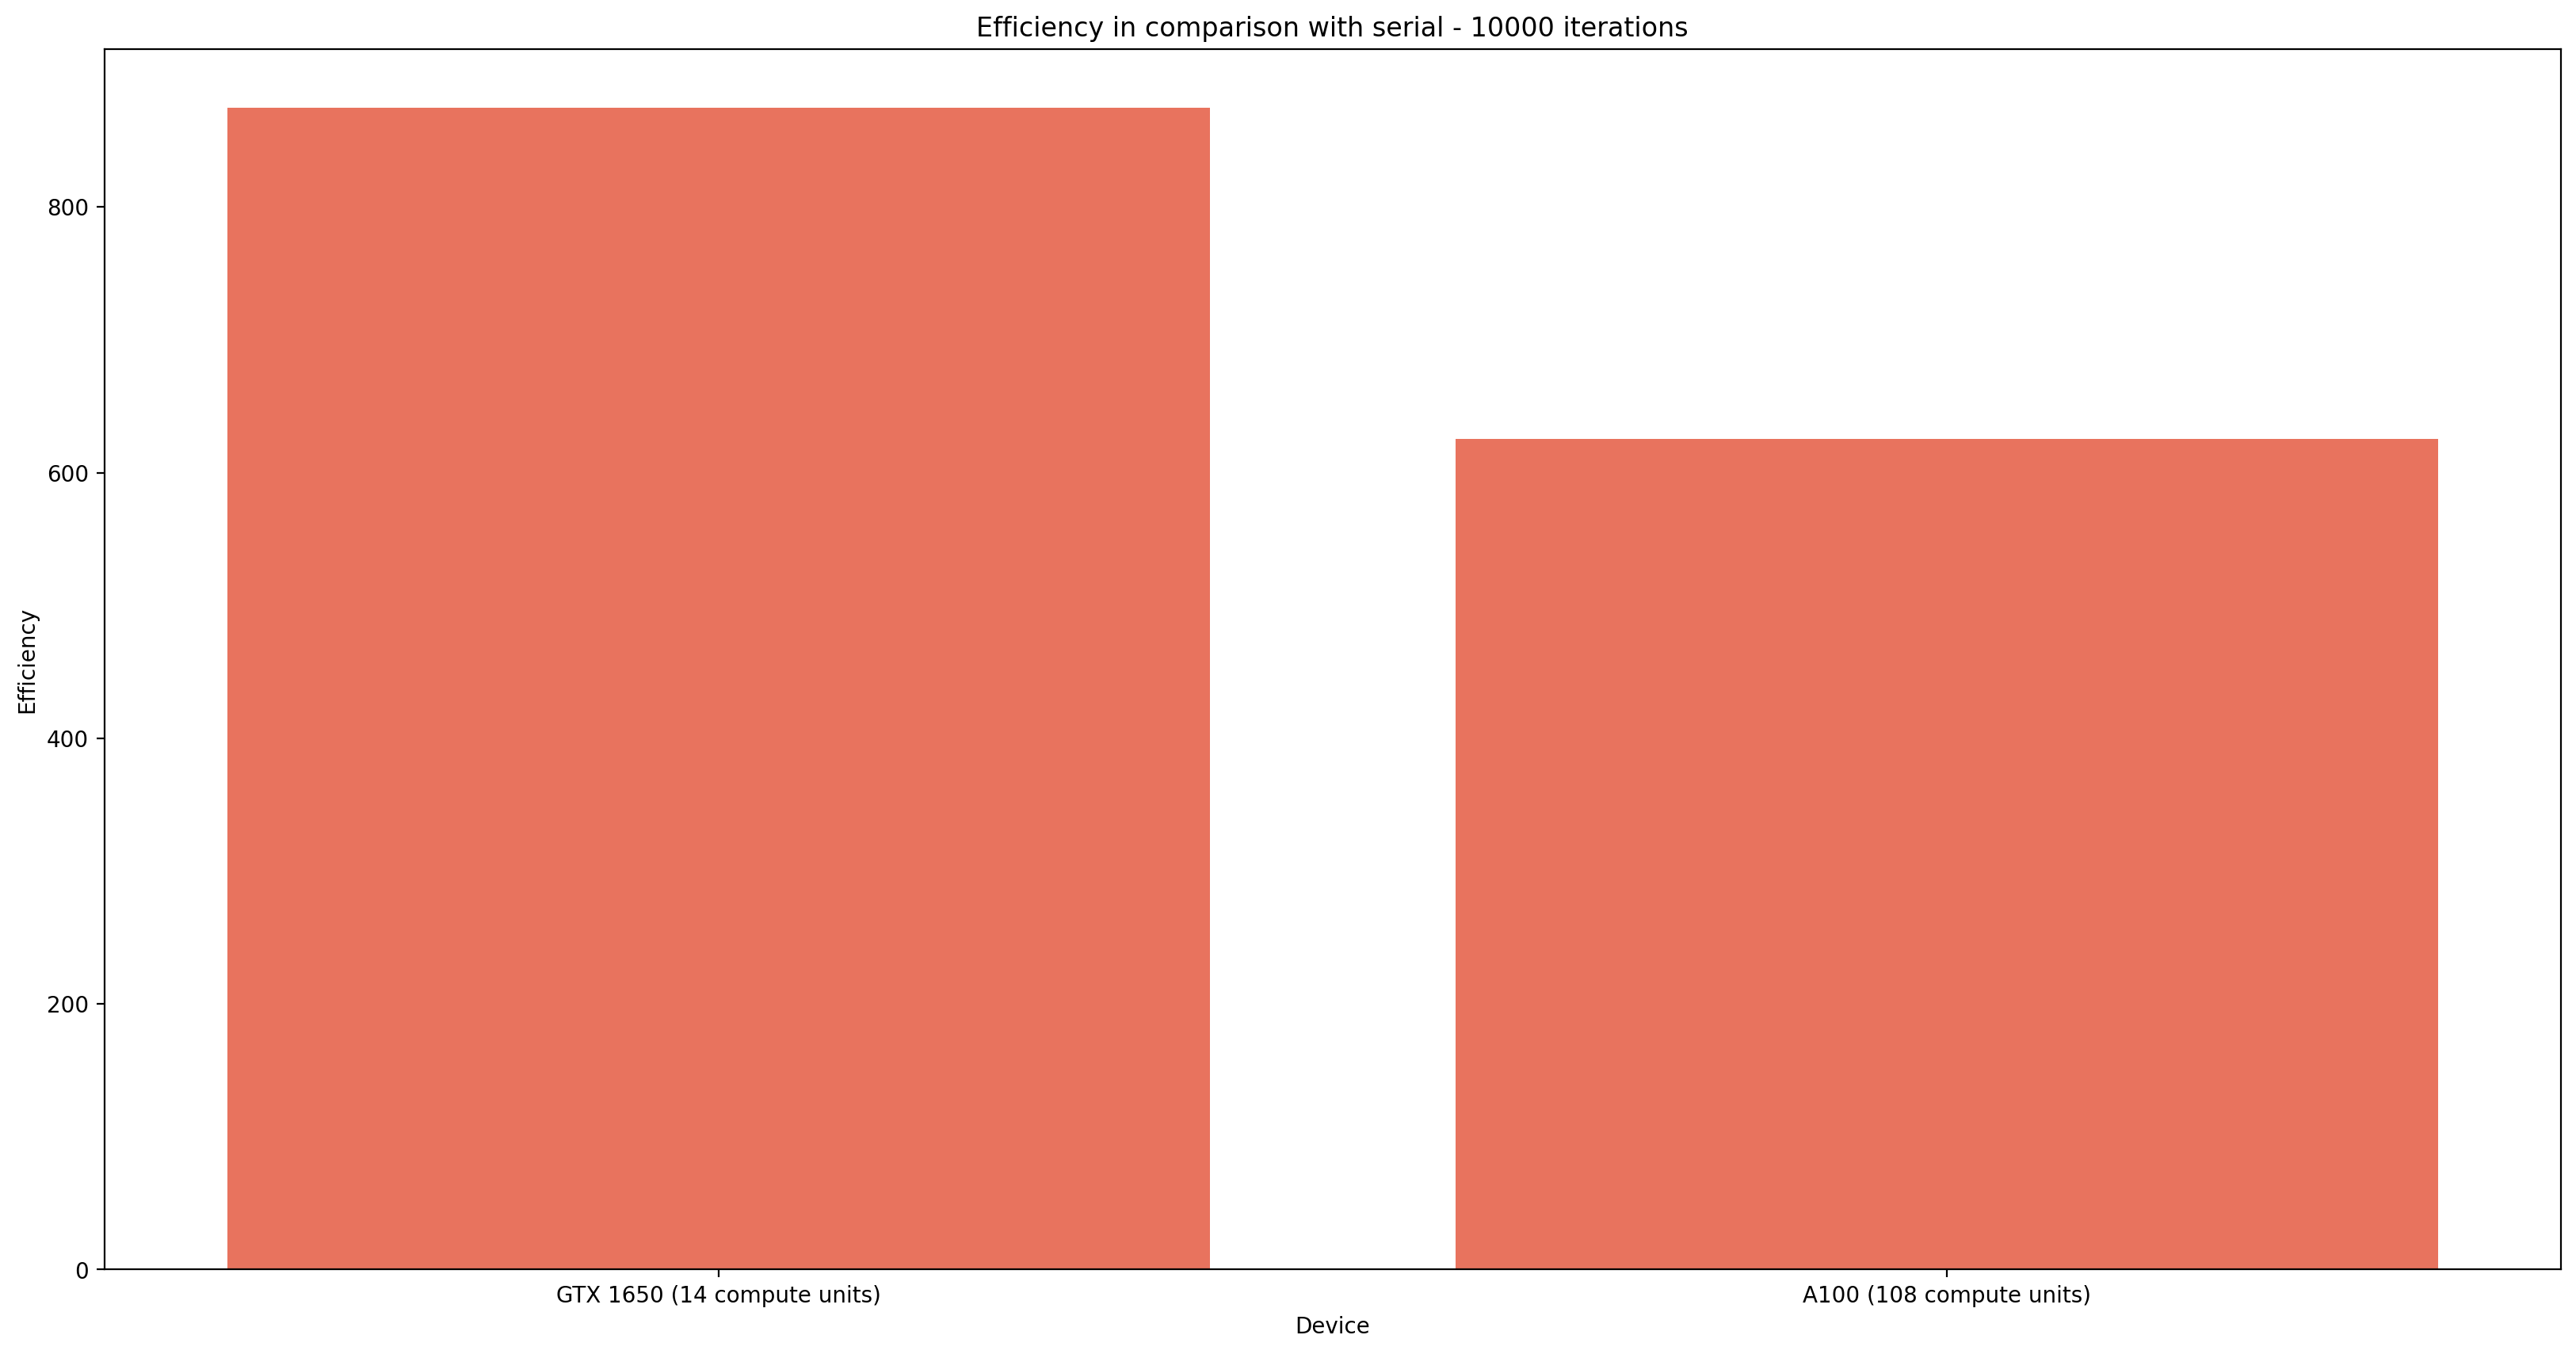

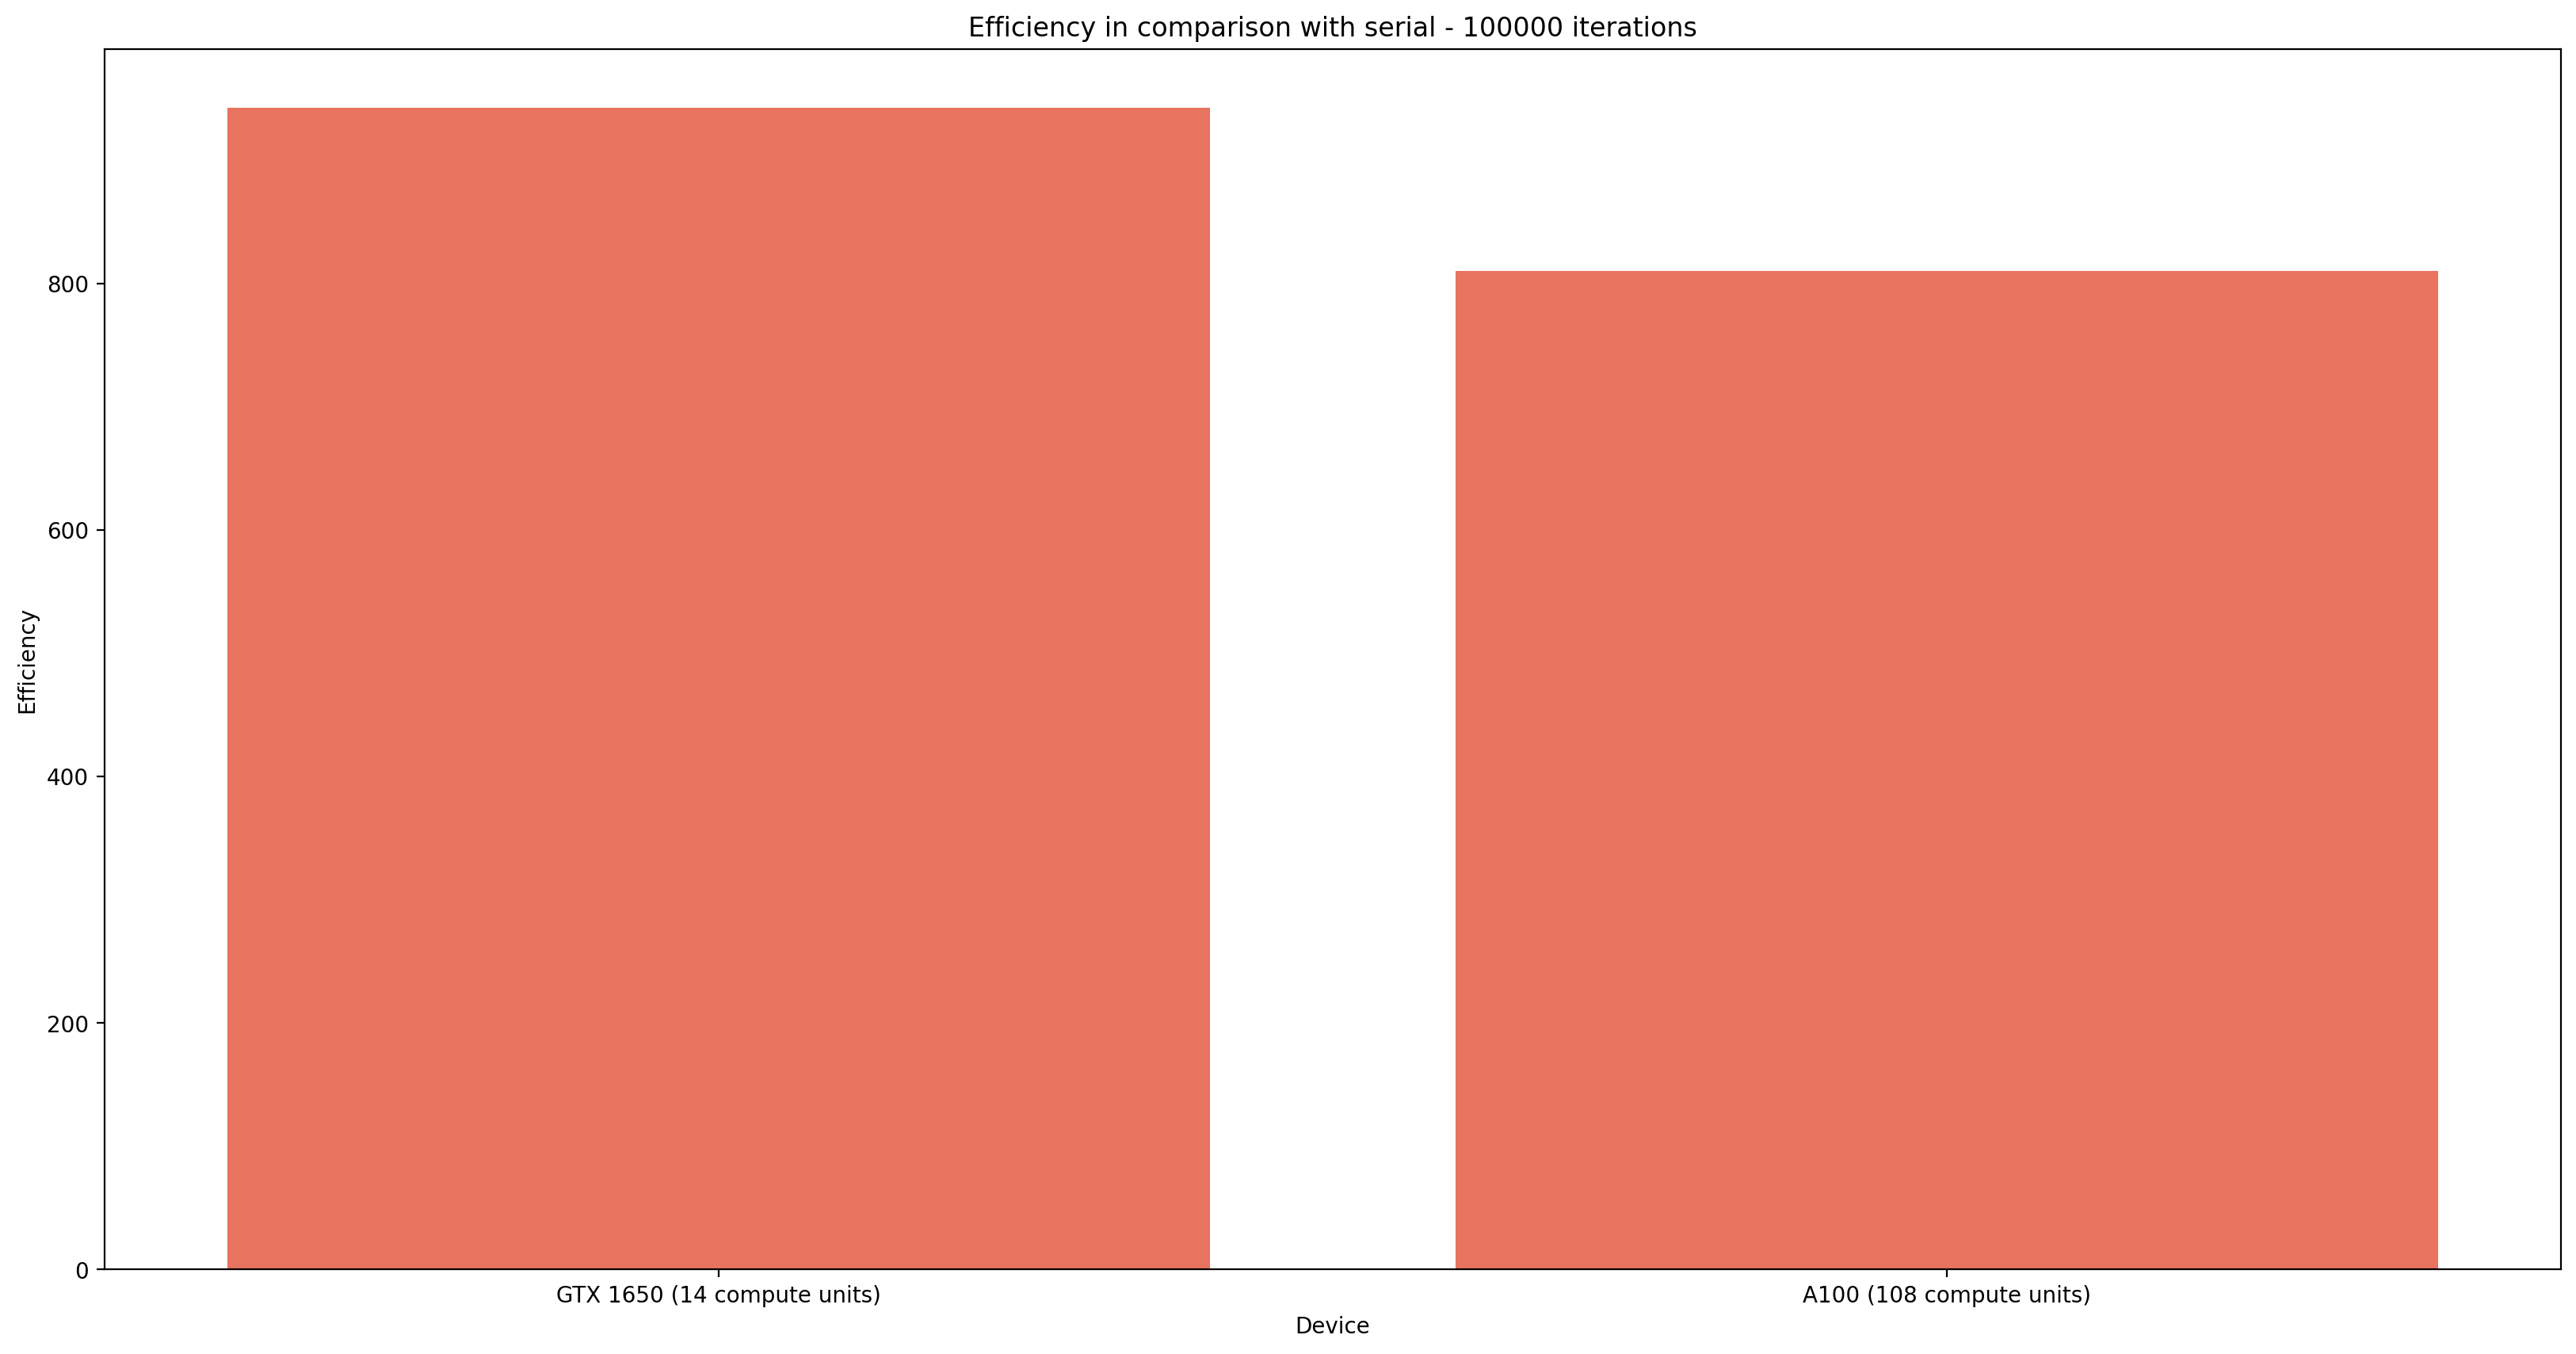

In [131]:
for it in grouped_by_iterations["iterations"].unique():
    plt.figure(figsize=(20, 10), dpi=200)
    chart = sns.barplot(
        grouped_by_iterations[
            (grouped_by_iterations["iterations"] == it)
            & (grouped_by_iterations["threads"] != 0)
            & (grouped_by_iterations["threads"] != 10)
        ],
        x=["GTX 1650 (14 compute units)", "A100 (108 compute units)"],
        y="efficiency_serial",
        color="tomato",
        legend=True,
    )
    chart.set_ylabel("Efficiency")
    chart.set_xlabel("Device")
    chart.set_title(f"Efficiency in comparison with serial - {it} iterations")
    plt.savefig(f"charts/efficiency_serial_{it}.png", bbox_inches="tight")

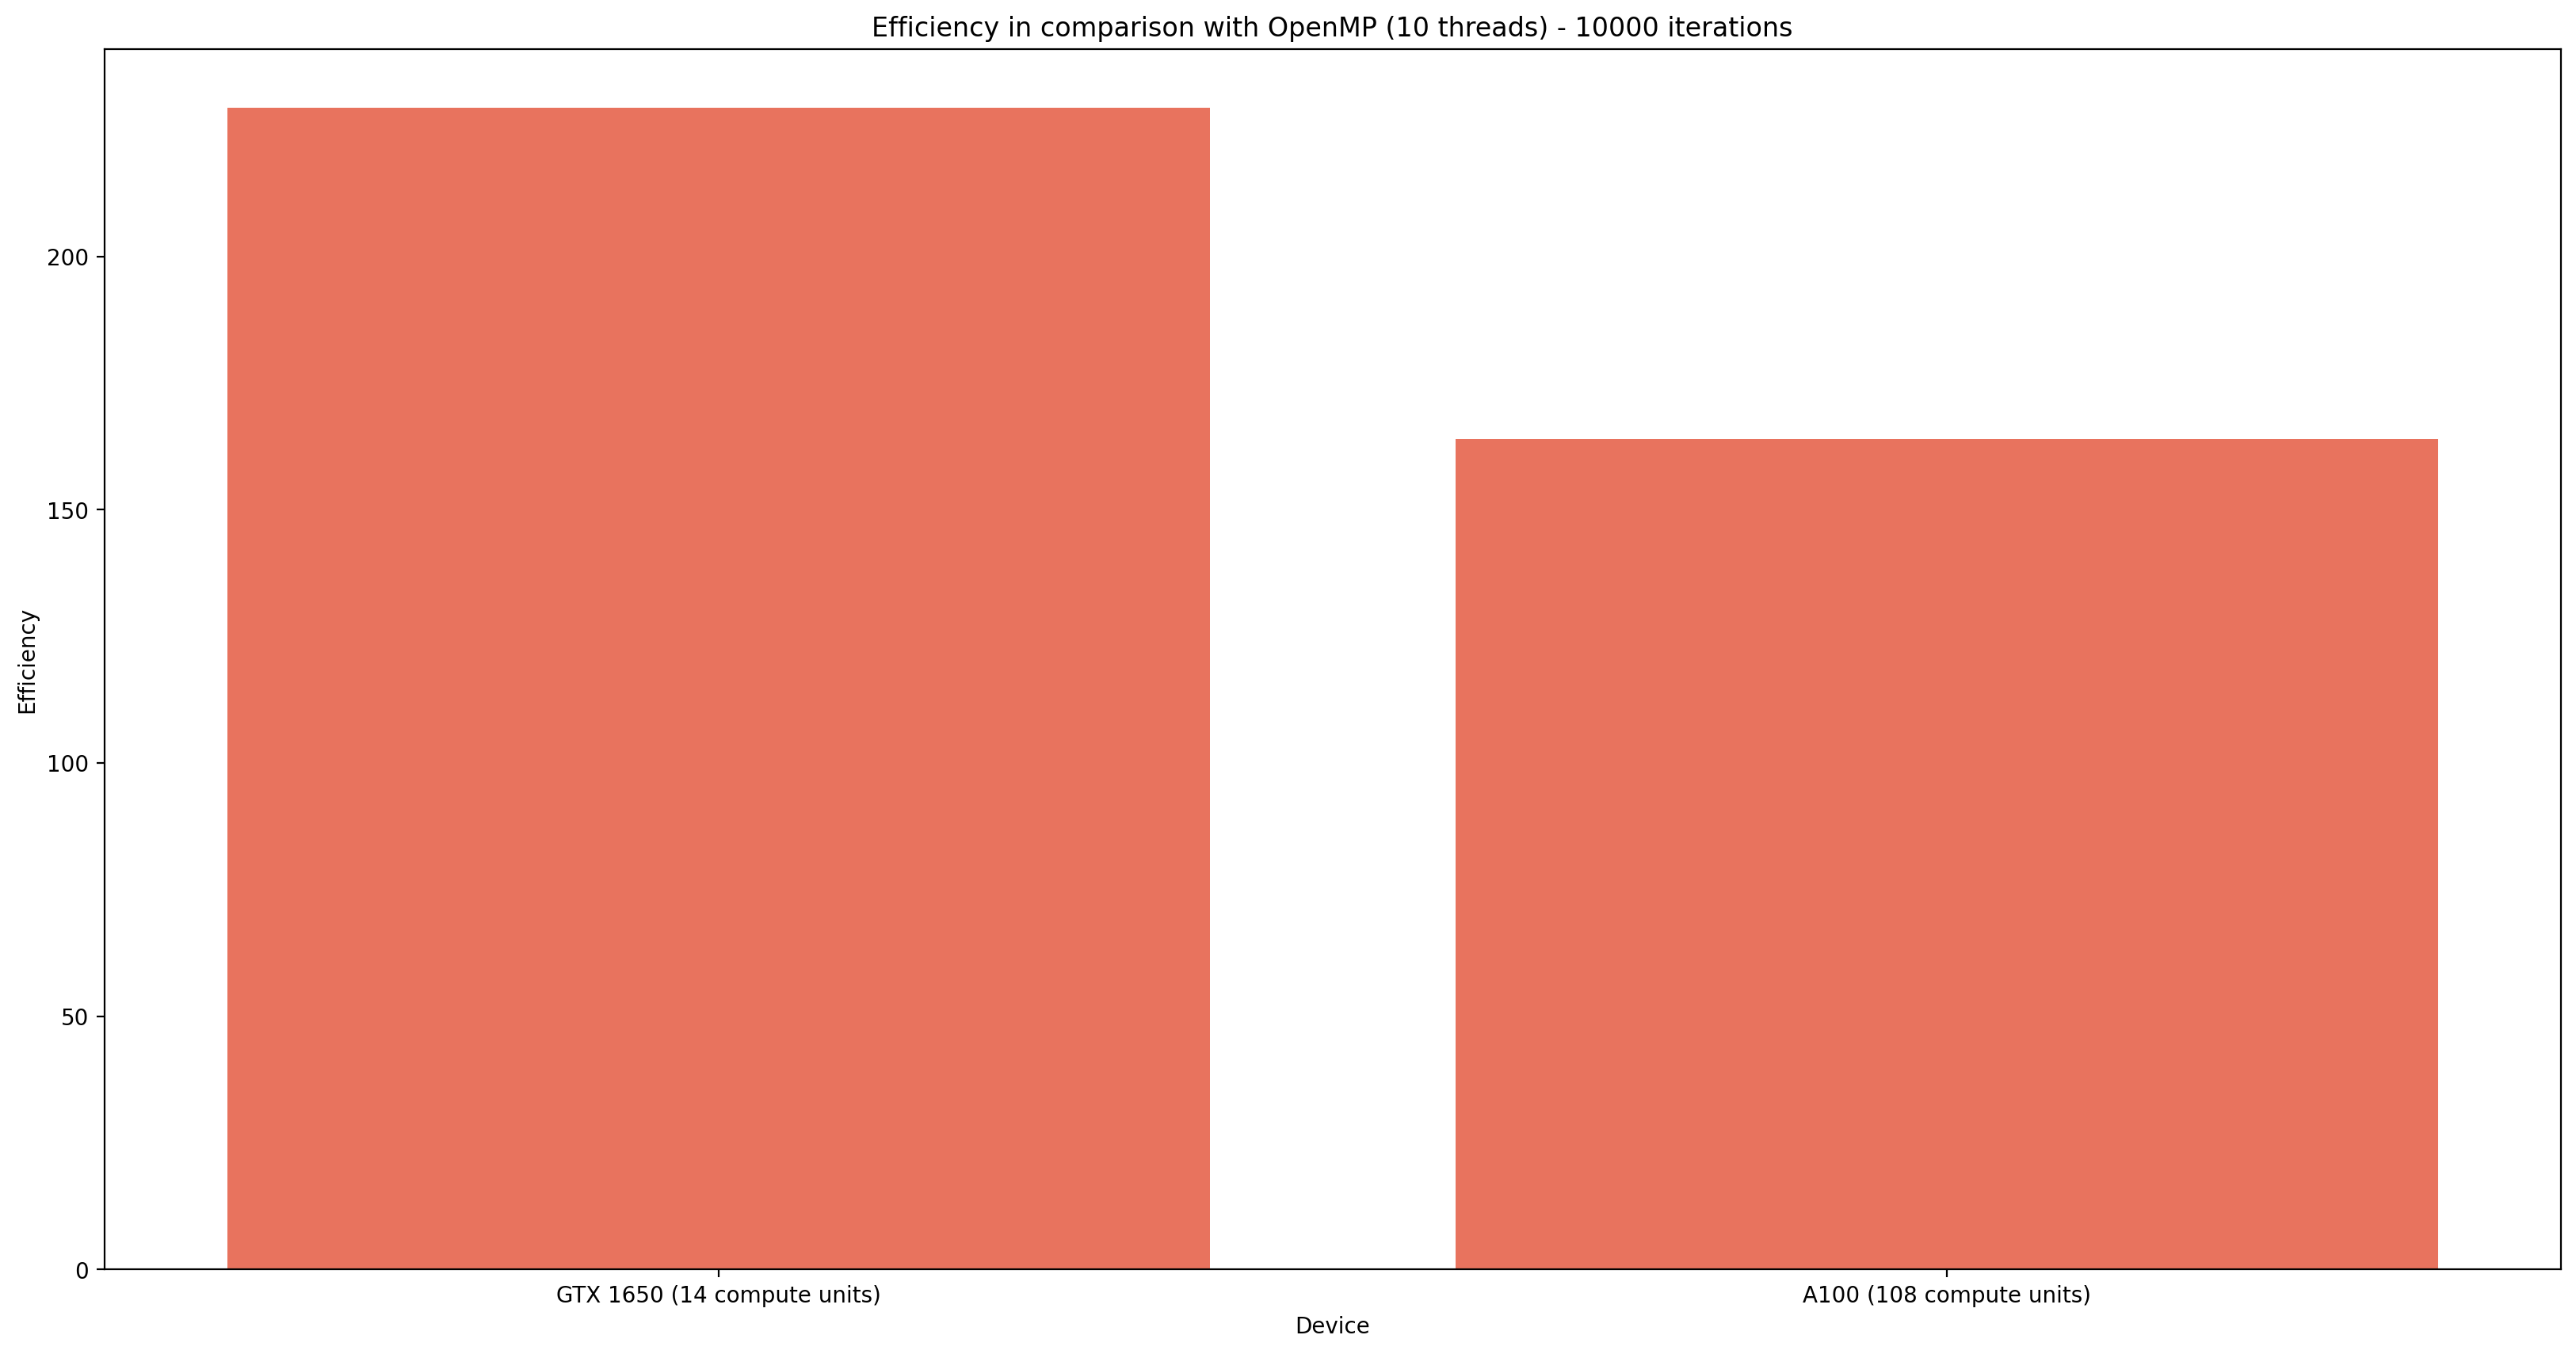

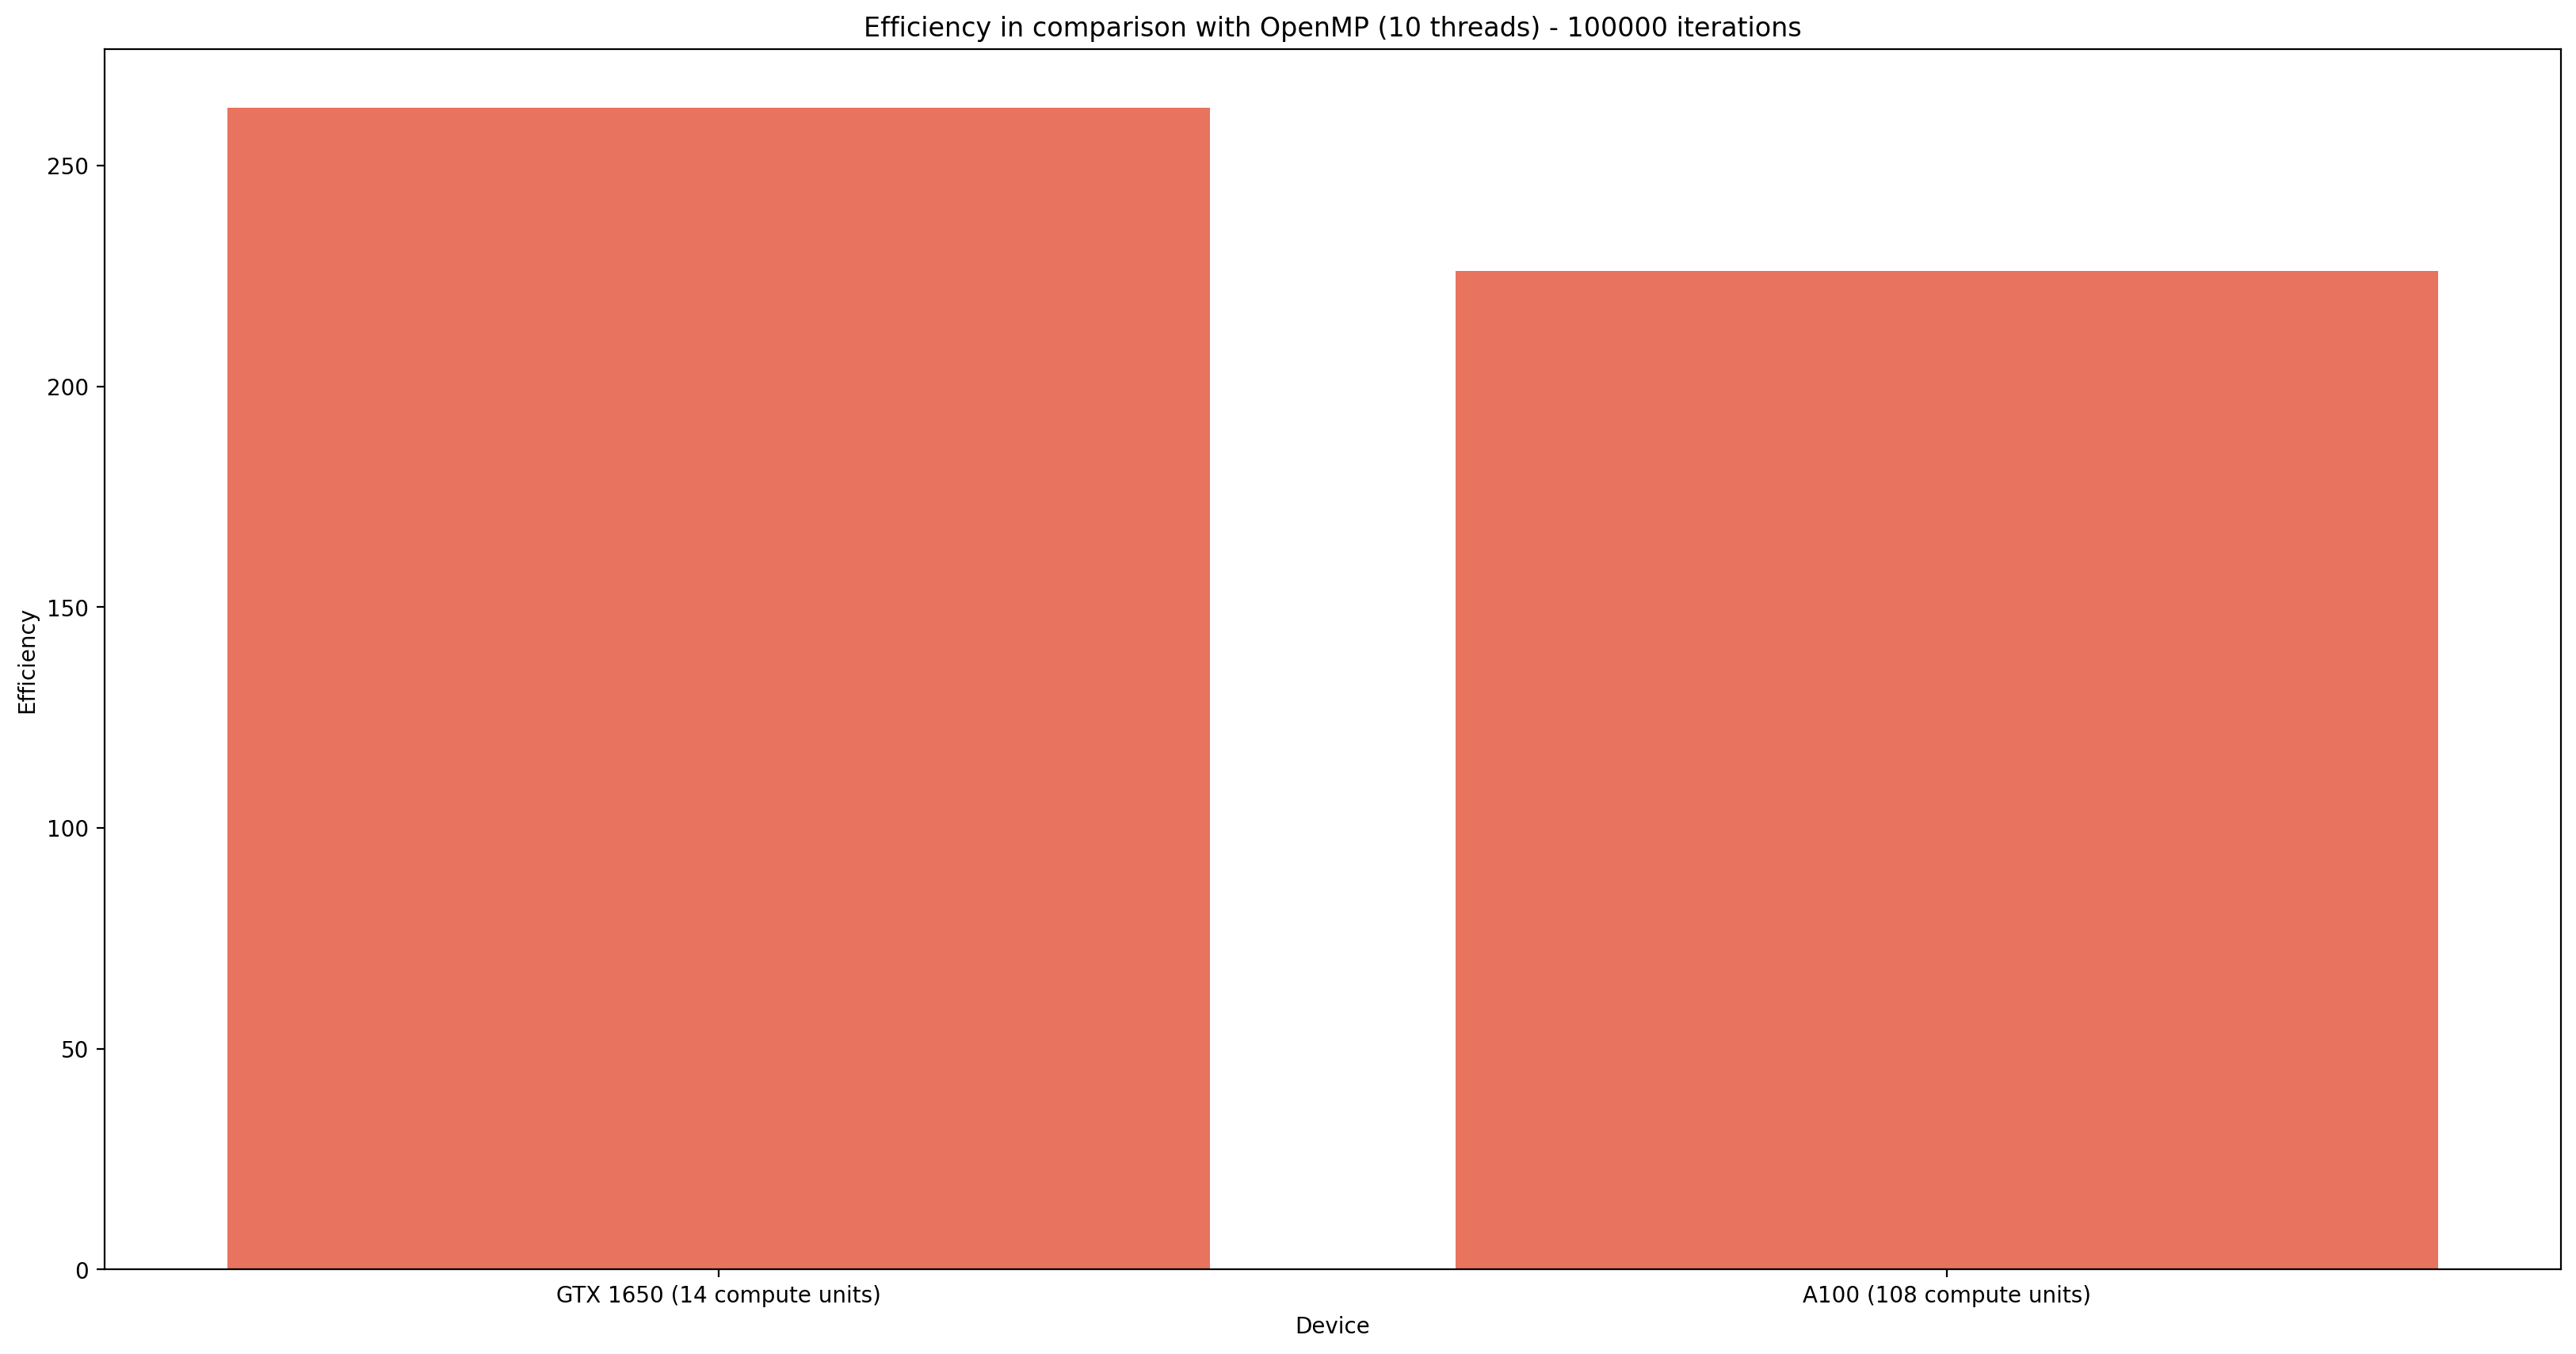

In [132]:
for it in grouped_by_iterations["iterations"].unique():
    plt.figure(figsize=(20, 10), dpi=200)
    chart = sns.barplot(
        grouped_by_iterations[
            (grouped_by_iterations["iterations"] == it)
            & (grouped_by_iterations["threads"] != 0)
            & (grouped_by_iterations["threads"] != 10)
        ],
        x=["GTX 1650 (14 compute units)", "A100 (108 compute units)"],
        y="efficiency_parallel",
        color="tomato",
        legend=True,
    )
    chart.set_ylabel("Efficiency")
    chart.set_xlabel("Device")
    chart.set_title(
        f"Efficiency in comparison with OpenMP (10 threads) - {it} iterations"
    )
    plt.savefig(f"charts/efficiency_parallel_{it}.png", bbox_inches="tight")